## Imports & Functions

### Imports

In [381]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

import time

from datetime import datetime

import requests # Ask to connect with something
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import xml.etree.ElementTree as ET  # for parsing XML

from pprint import pprint

from IPython.display import Image, display, Markdown

import nltk
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


### Functions

In [365]:
# Function to show the dimensions, column zero counts, column datatypes, column non-null counts, and the first and last 5 rows of the input dataframe
def check_df(df):
    # Display the dimensions of the DataFrame
    display(Markdown("#### DataFrame Dimensions"))
    display(df.shape)

    # Add a new line
    display(Markdown("<br>"))

    # Display the counts of zeros in each column
    display(Markdown("#### Zero Counts per Column"))
    display((df == 0).sum())

    # Add a new line
    display(Markdown("<br>"))

    # Display the data type and count of non-nulls in each column
    display(Markdown("#### Non-Null Counts & Data Types per Column"))
    display(df.info(show_counts=True))

    # Add a new line
    display(Markdown("<br>"))

    # Display the first 5 rows of the DataFrame
    display(Markdown("#### First 10 Rows"))
    display(df.head(5))

    # Add a new line
    display(Markdown("<br>"))

    # Display the last 5 rows of the DataFrame
    display(Markdown("#### Last 10 Rows"))
    display(df.tail(5))

# Function returns a dataframe null_counts_df which shows the count of nulls and the percentage of nulls in each column
def null_count(df):
    # Count of null values in each column
    null_counts_df = df.isnull().sum()

    # Total counts in each column (excluding nulls)
    total_counts_df = pd.DataFrame(df.shape[0], index=null_counts_df.index, columns=['Total count'])

    # Showing results in a dataframe
    null_counts_df = pd.DataFrame(null_counts_df, columns=['null counts'])
    null_counts_df['% of nulls'] = ((null_counts_df['null counts'] / total_counts_df['Total count']) * 100).round(2)

    return null_counts_df

# Function returns a dataframe zero_counts_df which shows the count of zeros and the percentage of zeros in each column
def zero_count (df):
    zero_counts_df = (df == 0).sum()

    # Total counts in each column
    total_counts_df=pd.DataFrame(df.count())

    # Showing results in a dataframe
    zero_counts_df = pd.DataFrame(zero_counts_df)
    zero_counts_df['% of zeros'] = ((zero_counts_df/total_counts_df)*100).round(2)
    zero_counts_df.rename(columns={0:'zero counts'}, inplace=True)

    return zero_counts_df

# Function to return a dataframe with rows filtered by a specified word in a specified column:
def df_keyword_search(df, column, word):
    # Ensure the column is treated as strings and handle NaN values by replacing them with empty strings
    column_data = df[column].fillna('').astype(str)
    
    # Filter the DataFrame based on the presence of the word in the specified column, case insensitive
    keyword_df = df.loc[column_data.str.contains(rf'\b{word}\b', case=False, regex=True)]
    
    return keyword_df

# Function that converts a string to lowercase, and replaces whitespace with underscores, unless the whitespace is adjacent to ' // '
def format_text(words):
    # converts the string to lowercase
    result = str(words).lower()

    # replaces whitespace with underscores, unless the whitespace is adjacent to ' // '
    return(re.sub(r'(?<!//)\s(?!//)', '_',result))

# Function to replace '//' with ''
def remove_double_slashes(text):
    return text.replace(' // ', ' ')

# Function to count the different words
def count_words(df, column):
    # Ensure the column is treated as strings, handling NaN values
    column = df[column].fillna('').astype(str)
    
    # Concatenate all values in the column into a single string with '//' as a separator
    all_words_sep = column.str.cat(sep='//')
    
    # Split the single string into words based on the separator
    all_words = all_words_sep.split('//')
    
    # Convert the list of words into a pandas Series
    words_series = pd.Series(all_words)
    
    # Count occurrences of each word and return the result
    word_counts = words_series.value_counts()

    # Convert the Series to a DataFrame with words and their counts
    word_counts_df = word_counts.reset_index()
    word_counts_df.columns = ['Word', 'Count']

    # Calculate the percentage of total counts
    total_count = word_counts_df['Count'].sum()
    word_counts_df['Percentage'] = round((word_counts_df['Count'] / total_count) * 100,2)
    
    return word_counts_df

# Function to find all games in a dataframe which contain a term, and then take the average of the numerical values of a selected column for all returned games
def search_and_average(df, search_column, search_term, avg_column):
    # Filter the rows where the search term is found in the search column
    filtered_df = df[df[search_column].astype(str).str.contains(search_term, case=False, na=False)]
    
    # Exclude rows where the avg_column contains zero
    filtered_df = filtered_df[filtered_df[avg_column] != 0]
    
    # Calculate the average of the second column for the filtered rows
    avg_value = filtered_df[avg_column].mean()
    
    return avg_value

## Ranked BGG Board Games

### Creating dataframe

In [6]:
# Creating dataframe from boardgames_ranks.csv data
rank_df = pd.read_csv('boardgames_ranks.csv')

In [13]:
# Checking contents of boardgames_ranks.csv
check_df(rank_df)

#### DataFrame Dimensions

(155634, 16)

<br>

#### Zero Counts per Column

id                          0
name                        0
yearpublished           11558
rank                   129072
bayesaverage           118638
average                 34862
usersrated              34862
is_expansion           122439
abstracts_rank              0
cgs_rank                    0
childrensgames_rank         0
familygames_rank            0
partygames_rank             0
strategygames_rank          0
thematic_rank               0
wargames_rank               0
dtype: int64

<br>

#### Non-Null Counts & Data Types per Column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155634 entries, 0 to 155633
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   155634 non-null  int64  
 1   name                 155634 non-null  object 
 2   yearpublished        155634 non-null  int64  
 3   rank                 155634 non-null  int64  
 4   bayesaverage         155634 non-null  float64
 5   average              155634 non-null  float64
 6   usersrated           155634 non-null  int64  
 7   is_expansion         155634 non-null  int64  
 8   abstracts_rank       1435 non-null    float64
 9   cgs_rank             359 non-null     float64
 10  childrensgames_rank  1060 non-null    float64
 11  familygames_rank     3219 non-null    float64
 12  partygames_rank      897 non-null     float64
 13  strategygames_rank   2946 non-null    float64
 14  thematic_rank        1653 non-null    float64
 15  wargames_rank    

None

<br>

#### First 10 Rows

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
0,224517,Brass: Birmingham,2018,1,8.41509,8.59780,45924,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,161936,Pandemic Legacy: Season 1,2015,2,8.37995,8.52747,53515,0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
2,174430,Gloomhaven,2017,3,8.35320,8.58904,62182,0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN
3,342942,Ark Nova,2021,4,8.33425,8.53493,43527,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.24195,8.60175,23816,0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN


<br>

#### Last 10 Rows

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
155629,423871,"Worldspanner Factions, Set 2: Expanses",2024,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155630,423872,Khanhoo Master,2022,0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155631,423873,"Worldspanner Factions, Set 3: Foes",2024,0,0.0,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155632,423889,Chicago Grand Slam,2024,0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155633,423890,Cyberpunk Unfolds: Pop-Up Mystery Escape Game,2024,0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Metadata

##### id
This is the identification number given by Board Game Geek to each game

##### name  
This is the name of the game.

##### Average
The average user rating, based on individual ratings out of 10.

##### bayesaverage
Statistical technique used to calculate a more reliable average by incorporating prior knowledge or assumptions about the data. 
These assumptions include:
- Prior Mean - the average rating across all games assumed before observing any data
- Prior Count - weighting of prior belief about the prior mean, balances the influence of observed data against prior assumption (if high the bayes average will be close ot the prior mean, if low, it willbe more influenced by actual observed data)

##### usersrated
This is just the number of people who have voted.

##### abstracts_rank:
"Abstract game" often refers to games of perfect information with alternating turns and no randomness; usually for 2 players.
It is also often used to refer to a game without a theme (regardless of the game mechanics).  
https://boardgamegeek.com/wiki/page/Abstract_Games&redirectedfrom=Abstract_Strategy  
https://boardgamegeek.com/abstracts/browse/boardgame

##### cgs_rank
Custom Game System Rank. It is a specific ranking for games that fall under custom or special rankings created by users or groups within the BGG community.  
https://boardgamegeek.com/cgs/browse/boardgame

##### childrensgames_rank  
Childrens games are designed specifically for children generally under the age of 10.  
https://boardgamegeek.com/childrensgames/browse/boardgame.  

##### familygames_rank  
Family games are accessible for a broad audience, including adults, teenagers, and children, typically ages 8 and up.  
https://boardgamegeek.com/familygames/browse/boardgame

##### partygames_rank  
Party games are designed ot be played in causal, social setting, often with large groups of people.  
https://boardgamegeek.com/partygames/browse/boardgame

##### strategygames_rank  
Strategy games emphasize strategic thinking, planning, and decision-making over luck or simple mechanics.  
https://boardgamegeek.com/strategygames/browse/boardgame

##### thematic_rank  
Thematic games are characterized by their strong storytelling elements, immersive themes, and emphasis on the narrative experience.  
https://boardgamegeek.com/thematic/browse/boardgame

##### wargames_rank  
Wargames simulate military conflicts, battles, or wars, often focusing on historical accuracy, strategy, and tactical decision-making.  
https://boardgamegeek.com/wargames/browse/boardgame

#### Formatting

In [8]:
# Changing each string element of the dataframe to lower case to support with EDA
rank_df = rank_df.map(lambda x: x.lower() if isinstance(x, str) else x)

# Checking changes have been made
rank_df.head(5)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
0,224517,brass: birmingham,2018,1,8.41509,8.59780,45924,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,161936,pandemic legacy: season 1,2015,2,8.37995,8.52747,53515,0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
2,174430,gloomhaven,2017,3,8.35320,8.58904,62182,0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN
3,342942,ark nova,2021,4,8.33425,8.53493,43527,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,233078,twilight imperium: fourth edition,2017,5,8.24195,8.60175,23816,0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN


### Ranked BGG EDA

#### Data types

In [20]:
print(rank_df.dtypes)

id                       int64
name                    object
yearpublished            int64
rank                     int64
bayesaverage           float64
average                float64
usersrated               int64
is_expansion             int64
abstracts_rank         float64
cgs_rank               float64
childrensgames_rank    float64
familygames_rank       float64
partygames_rank        float64
strategygames_rank     float64
thematic_rank          float64
wargames_rank          float64
dtype: object


#### Nulls and zeros

In [22]:
# Reviewing nulls & data types
rank_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155634 entries, 0 to 155633
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   155634 non-null  int64  
 1   name                 155634 non-null  object 
 2   yearpublished        155634 non-null  int64  
 3   rank                 155634 non-null  int64  
 4   bayesaverage         155634 non-null  float64
 5   average              155634 non-null  float64
 6   usersrated           155634 non-null  int64  
 7   is_expansion         155634 non-null  int64  
 8   abstracts_rank       1435 non-null    float64
 9   cgs_rank             359 non-null     float64
 10  childrensgames_rank  1060 non-null    float64
 11  familygames_rank     3219 non-null    float64
 12  partygames_rank      897 non-null     float64
 13  strategygames_rank   2946 non-null    float64
 14  thematic_rank        1653 non-null    float64
 15  wargames_rank    

In [23]:
# Shows a breakdown of null counts and percentage of null counts per column
null_count(rank_df)

,null counts,% of nulls
id,0,0.00
name,0,0.00
yearpublished,0,0.00
rank,0,0.00
bayesaverage,0,0.00
average,0,0.00
usersrated,0,0.00
is_expansion,0,0.00
abstracts_rank,154199,99.08
cgs_rank,155275,99.77


In [24]:
# Shows a breakdown of zero counts and percentage of zero counts per column
zero_count(rank_df)

,zero counts,% of zeros
id,0,0.00
name,0,0.00
yearpublished,11558,7.43
rank,129072,82.93
bayesaverage,118638,76.23
average,34862,22.40
usersrated,34862,22.40
is_expansion,122439,78.67
abstracts_rank,0,0.00
cgs_rank,0,0.00


#### Numerical values

In [26]:
# checking statistical summary of all numerical values of rank_df (excluding id)

rank_df.loc[:,['yearpublished','rank','bayesaverage','average','usersrated']].describe()

,yearpublished,rank,bayesaverage,average,usersrated
count,155634.000000,155634.000000,155634.000000,155634.000000,155634.000000
mean,1856.689187,2266.748930,1.349691,5.016631,184.850103
std,528.748693,5916.284292,2.422584,3.039383,1757.347603
min,-3500.000000,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,0.000000,0.000000,3.000000,1.000000
50%,2012.000000,0.000000,0.000000,6.000000,4.000000
75%,2019.000000,0.000000,0.000000,7.219387,26.000000
max,2028.000000,26562.000000,8.415090,10.000000,127831.000000


#### Year published

In [28]:
# rank_df filtered by year published in ascending order
rank_df.sort_values(by = 'yearpublished', ascending = True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
10121,2399,senet,-3500,10122,5.57084,5.83515,838,0,906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20962,11726,knucklebones,-3000,20963,5.50518,6.00000,42,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27579,4148,mehen,-3000,0,0.00000,5.33684,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26418,5546,marbles,-3000,26419,5.34831,4.74441,538,0,NaN,NaN,995.0,NaN,NaN,NaN,NaN,NaN
40581,23211,20 squares,-3000,0,0.00000,4.50000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152387,415216,hunter's crest: darkwood,2026,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133913,352225,terminus frontier,2026,0,0.00000,5.50000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148695,403137,versailles request,2026,0,0.00000,9.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114893,291276,criminal city,2026,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


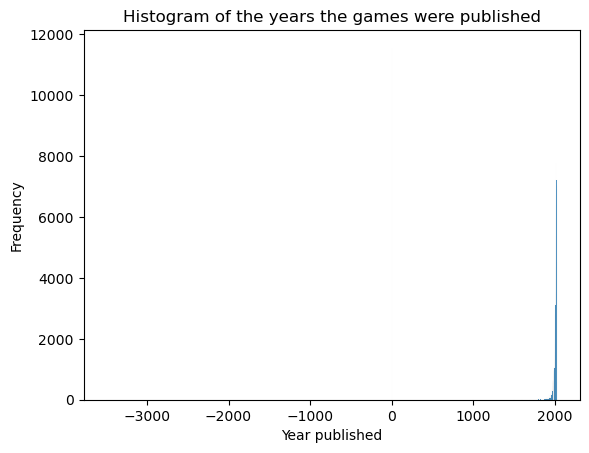

In [29]:
# Histogram plot of the year the game was published - no filters
sns.histplot(rank_df['yearpublished'])
plt.title('Histogram of the years the games were published')
plt.xlabel("Year published")
plt.ylabel("Frequency")
plt.show()

In [30]:
# rank_df filtered by year published for values which have 4 digits and for games made in and between 1900 to 2024
rank_df.loc[(rank_df['yearpublished'].astype(str).str.len() == 4) & 
            (rank_df['yearpublished']>=1900) &
            (rank_df['yearpublished']<2025)].sort_values(by = 'yearpublished', ascending = True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
46913,30982,grand national steeplechase game,1900,0,0.00000,4.47222,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116863,298140,the national football game,1900,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77034,139956,the merry game of bicycling,1900,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66919,100110,spin and old maid,1900,0,0.00000,5.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103956,247318,cake walk,1900,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6771,291334,tanto monta: the rise of ferdinand & isabella 1470-1516,2024,6772,5.64942,7.88970,190,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,799.0
146930,396953,the holiest crap,2024,0,0.00000,4.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133154,350240,history of the ancient seas: expansion iii – new armies,2024,0,0.00000,10.00000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151528,412522,bangarang,2024,0,0.00000,8.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


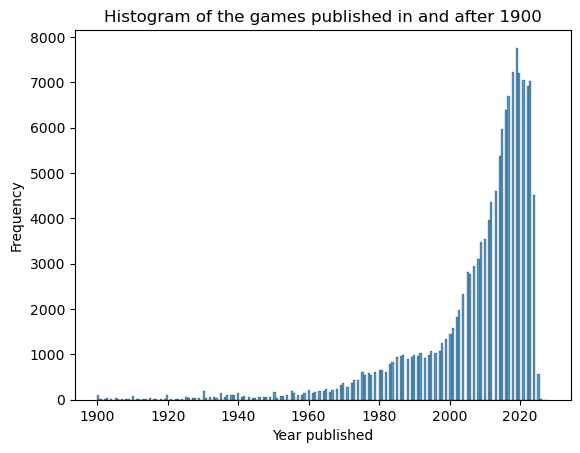

In [31]:
# Histogram plot of the games published in and after 1900
sns.histplot(rank_df.loc[(rank_df['yearpublished'].astype(str).str.len() == 4) & 
             (rank_df['yearpublished'] >= 1900),'yearpublished'])
plt.title('Histogram of the games published in and after 1900')
plt.xlabel("Year published")
plt.ylabel("Frequency")
plt.show()

In [32]:
# rank_df filtered by year published for values which have 4 digits and for games made in and between 1900 to 2024
rank_df.loc[(rank_df['yearpublished'].astype(str).str.len() == 4) & 
            (rank_df['yearpublished']>=1900) &
            (rank_df['yearpublished']<2025) &
            (rank_df['rank']>0)].sort_values(by = 'yearpublished', ascending = True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
17935,17183,1001,1900,17936,5.51686,6.42143,42,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14957,14765,tuppi,1900,14958,5.52952,7.22162,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24693,17755,schnipp schnapp,1900,24694,5.48216,4.80400,50,0,NaN,NaN,820.0,NaN,NaN,NaN,NaN,NaN
2044,140,pit,1903,2045,6.19281,6.39073,9554,0,NaN,NaN,NaN,752.0,200.0,NaN,NaN,NaN
26034,2294,flinch,1903,26035,5.44447,5.24904,489,0,NaN,NaN,NaN,3101.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15069,401505,fantasyform,2024,15070,5.52903,7.64516,31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9402,354335,palm laboratory,2024,9403,5.58199,7.35738,106,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15241,374130,tentricks,2024,15242,5.52827,6.95119,59,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17634,414082,woof days,2024,17635,5.51779,7.96176,34,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


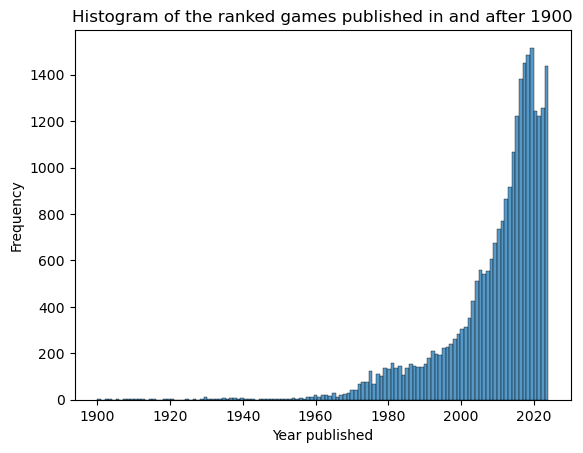

In [33]:
# Histogram plot of ranked games published in and between 1900 to 2024
sns.histplot(rank_df.loc[(rank_df['yearpublished'].astype(str).str.len() == 4) & 
            (rank_df['yearpublished']>=1900) &
            (rank_df['yearpublished']<2025) &
            (rank_df['rank']>0),'yearpublished'])
plt.title('Histogram of the ranked games published in and after 1900')
plt.xlabel("Year published")
plt.ylabel("Frequency")
plt.show()

#### Number of ratings per game

In [35]:
rank_df.loc[rank_df['usersrated'] == 0,'usersrated']

26635     0
26638     0
26669     0
26679     0
26680     0
         ..
155629    0
155630    0
155631    0
155632    0
155633    0
Name: usersrated, Length: 34862, dtype: int64

In [36]:
# Exploring the number of user ratings

# average number of ratings given excluding zero ratings
ave_rating_usersrated = rank_df.loc[(rank_df['usersrated']> 0),'usersrated'].mean()

# count of games with at least the average number of ratings given
ave_rating_usersrated_count = rank_df.loc[(rank_df['usersrated'] >= ave_rating_usersrated ),'usersrated'].count()

print(f"Number of games with no ratings given {rank_df.loc[rank_df['usersrated'] == 0,'usersrated'].count()}")
print(f"Number of games with ratings given {rank_df.loc[(rank_df['usersrated'] > 0),'usersrated'].count()}")
print(f"Average number of ratings given {ave_rating_usersrated.round(2)}")
print(f"Count of game with above the average number of ratings given {ave_rating_usersrated_count.round(2)}")
print(f"Percentage of games with a rating {(rank_df.loc[(rank_df['usersrated'] > 0),'usersrated'].count()/(len(rank_df))*100).round(2)} %")
print(f"Percentage of games with less than 10 ratings {(rank_df.loc[(rank_df['usersrated'] <= 10),'usersrated'].count()/(len(rank_df))*100).round(2)} %")

Number of games with no ratings given 34862
Number of games with ratings given 120772
Average number of ratings given 238.21
Count of game with above the average number of ratings given 11737
Percentage of games with a rating 77.6 %
Percentage of games with less than 10 ratings 63.79 %


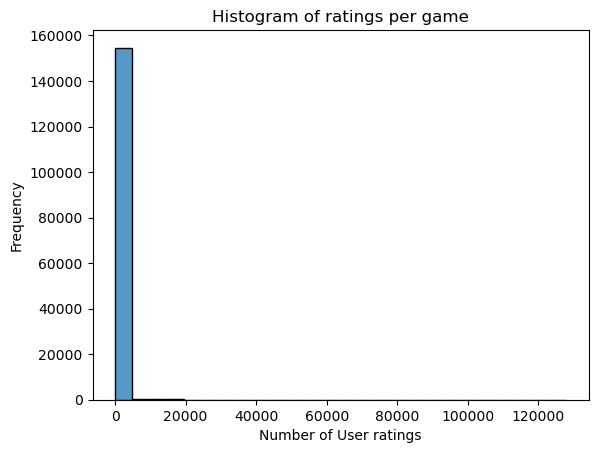

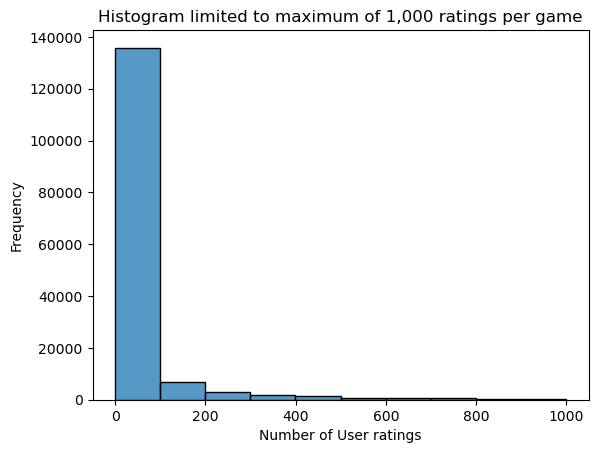

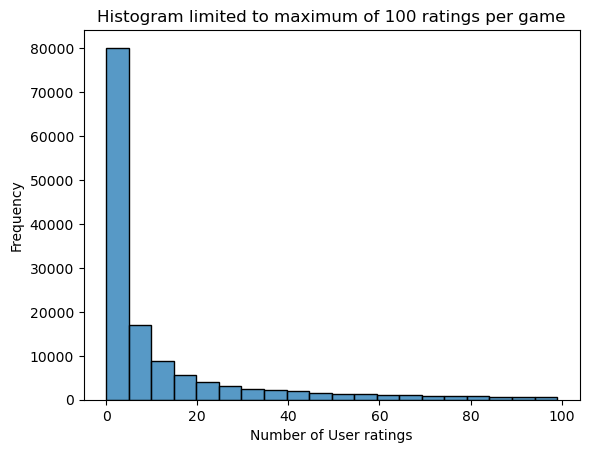

In [37]:
# Histogram based on number of user ratings
rank_df

sns.histplot(rank_df['usersrated'], binwidth=5000)
plt.title('Histogram of ratings per game')
plt.xlabel("Number of User ratings")
plt.ylabel("Frequency")
plt.show()

# Limiting to 1,000 ratings
sns.histplot(rank_df.loc[(rank_df.usersrated < 1000),'usersrated'], binwidth=100)
plt.title('Histogram limited to maximum of 1,000 ratings per game')
plt.xlabel("Number of User ratings")
plt.ylabel("Frequency")
plt.show()

# Limiting to 100 ratings
sns.histplot(rank_df.loc[(rank_df.usersrated < 100),'usersrated'], binwidth=5)
plt.title('Histogram limited to maximum of 100 ratings per game')
plt.xlabel("Number of User ratings")
plt.ylabel("Frequency")
plt.show()

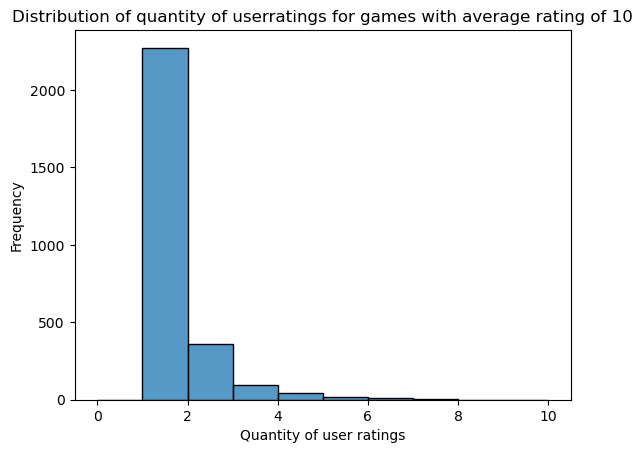

In [38]:
## Only considering games with ratings of 10

# Distribution of average rating for ranked games
sns.histplot(rank_df.loc[(rank_df.average==10),'usersrated'],binrange=(0,10),binwidth=1)
plt.title('Distribution of quantity of userratings for games with average rating of 10')
plt.xlabel("Quantity of user ratings")
plt.ylabel("Frequency")
plt.show()

In [39]:
rank_df.loc[(rank_df.average==10)].sort_values('usersrated',ascending= False).head(10)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
139682,369988,saurvival,2022,0,0.0,10.0,17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38273,20244,zombie from the hole,2007,0,0.0,10.0,17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141136,374635,ritos ancestrais,2023,0,0.0,10.0,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144474,385412,jogando com lovecraft,2023,0,0.0,10.0,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107061,260129,ready set battle,2019,0,0.0,10.0,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111401,277803,cycle of prophecy,0,0,0.0,10.0,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153217,418073,imperial borders,2025,0,0.0,10.0,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140131,371360,ravens,2022,0,0.0,10.0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145296,388923,legend of kartlos,2023,0,0.0,10.0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147964,401213,i am champion,2023,0,0.0,10.0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


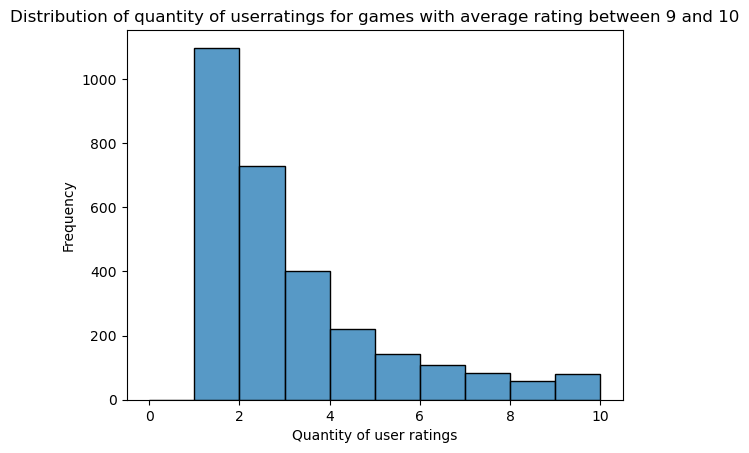

In [40]:
# Distribution of average rating for ranked games
sns.histplot(rank_df.loc[(rank_df.average >= 9) & (rank_df.average < 10),'usersrated'],binrange=(0,10),binwidth=1)
plt.title('Distribution of quantity of userratings for games with average rating between 9 and 10')
plt.xlabel("Quantity of user ratings")
plt.ylabel("Frequency")
plt.show()

In [41]:
rank_df.loc[(rank_df.average >= 9) & (rank_df.average < 10)].sort_values('usersrated',ascending= False).tail(10)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
103629,245749,to the death!,2018,0,0.0,9.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103655,245861,spice empires,0,0,0.0,9.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103723,246251,rune society,2018,0,0.0,9.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103748,246321,geargrid,2018,0,0.0,9.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138750,367555,starforce commander,2022,0,0.0,9.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103964,247385,admiral: captain's cards,2013,0,0.0,9.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104018,247639,council of blackthorn: casting doubt,2019,0,0.0,9.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104085,247884,holistic: quint sequencing card game,2018,0,0.0,9.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138529,366674,home from oz: expanded starter set,2022,0,0.0,9.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120368,308690,bolt action: campaign – mariana & palau islands,2020,0,0.0,9.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Average ratings per game

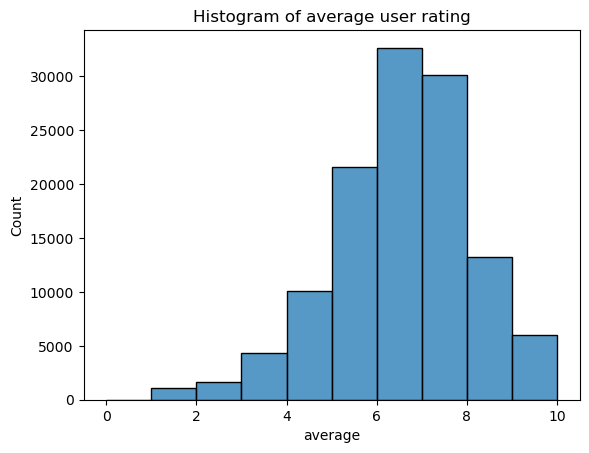

The average of the average user rating for games with more than 0 ratings = 6.46
The median for the average user rating for games with more than 0 ratings = 6.6


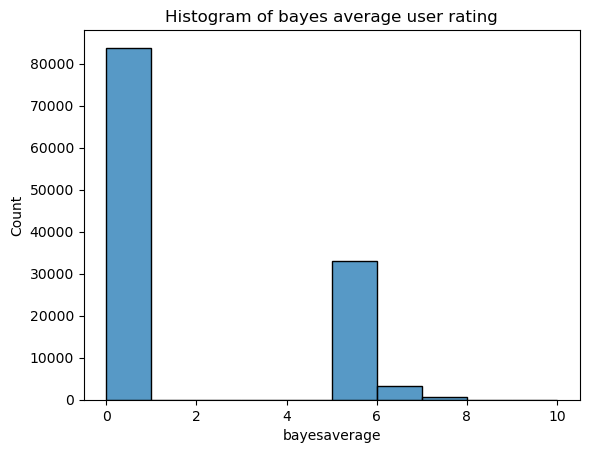

The average of the bayes average user rating for games with more than 0 ratings = 1.74
The median for the bayes average user rating for games with more than 0 ratings = 0.0


In [43]:
# Histogram based on average user rating, for games with a rating
sns.histplot(rank_df.loc[(rank_df.usersrated >0),'average'],binrange=(0,10),binwidth=1)
plt.title('Histogram of average user rating')
plt.show()

print(f'The average of the average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >0),'average'].mean().round(2))
print(f'The median for the average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >0),'average'].median())

# Histogram based on Bayes average user rating, for games with a rating
sns.histplot(rank_df.loc[(rank_df.usersrated >0),'bayesaverage'],binrange=(0,10),binwidth=1)
plt.title('Histogram of bayes average user rating')
plt.show()

print(f'The average of the bayes average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >0),'bayesaverage'].mean().round(2))
print(f'The median for the bayes average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >0),'bayesaverage'].median())

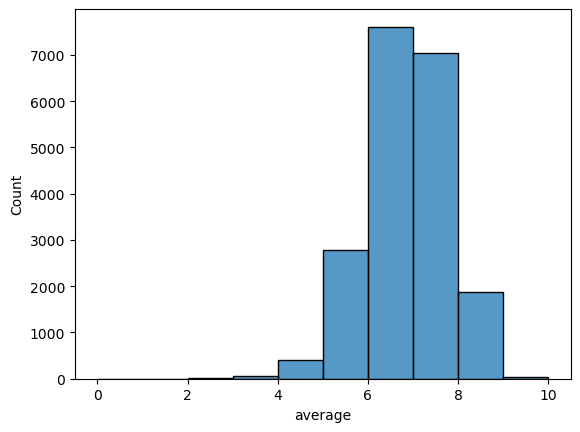

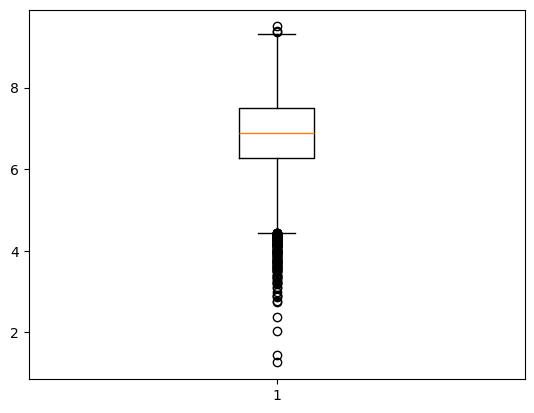

The average of the average user rating for games with more than 0 ratings = 6.85
The median for the average user rating for games with more than 0 ratings = 6.88081


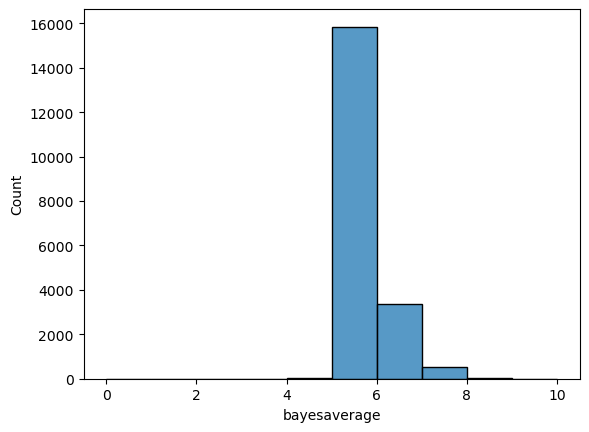

The average of the average user rating for games with more than 0 ratings = 5.81
The median for the average user rating for games with more than 0 ratings = 5.6514


In [44]:
# Histogram based on average user rating, for games with a rating of 100 or more
sns.histplot(rank_df.loc[(rank_df.usersrated >=100),'average'],binrange=(0,10),binwidth=1)
plt.show()

plt.boxplot(rank_df.loc[(rank_df.usersrated >=100),'average'])
plt.show()

print(f'The average of the average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >=100),'average'].mean().round(2))
print(f'The median for the average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >=100),'average'].median())

# Histogram based on Bayes average user rating, for games with a rating of 100 or more
sns.histplot(rank_df.loc[(rank_df.usersrated >=100),'bayesaverage'],binrange=(0,10),binwidth=1)
plt.show()

print(f'The average of the average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >=100),'bayesaverage'].mean().round(2))
print(f'The median for the average user rating for games with more than 0 ratings =',rank_df.loc[(rank_df.usersrated >=100),'bayesaverage'].median())

In [45]:
ratings_count = rank_df.loc[(rank_df.usersrated > 0),'average'].count()
ratings_ave = rank_df.loc[(rank_df.usersrated > 0),'average'].mean()
print(f'Number of games with average ratings given {ratings_count}')
print(f'Average of average ratings given {ratings_ave}')

Number of games with average ratings given 120772
Average of average ratings given 6.46472942859272


#### Game rankings

In [47]:
# Bottom of the ranked table
rank_df.loc[rank_df.get('rank') == 0].head(10).sort_values('usersrated',ascending = False)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
26569,177,advanced civilization,1991,0,6.98546,8.01172,3355,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26571,227,knightmare chess,1994,0,5.85876,6.44432,1389,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26568,158,elfengold,1999,0,5.84885,6.94788,659,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26564,81,"eurofront: war in europe, 1939-45",1995,0,5.56359,7.08229,96,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26563,80,volgafront: east of eastfront 1942-43,1994,0,5.56201,7.57536,69,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26566,123,green thumb cards,1996,0,0.00000,7.31034,29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26562,65,the garden game,1996,0,0.00000,4.08929,28,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26565,107,peaceful resistance,1995,0,0.00000,5.72353,17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26567,143,wortelboer,1999,0,0.00000,4.17647,17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26570,203,skworms,1997,0,0.00000,4.00000,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


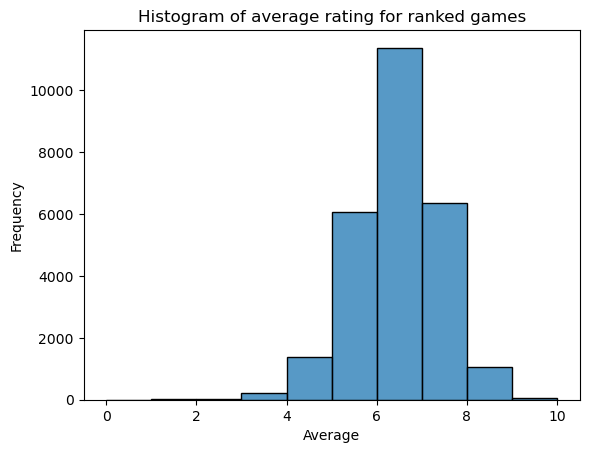

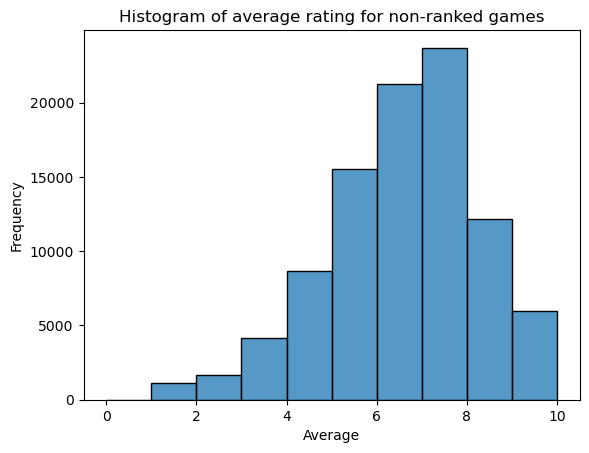

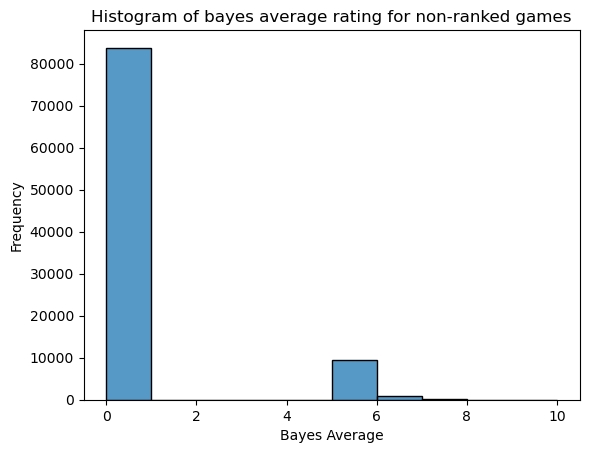

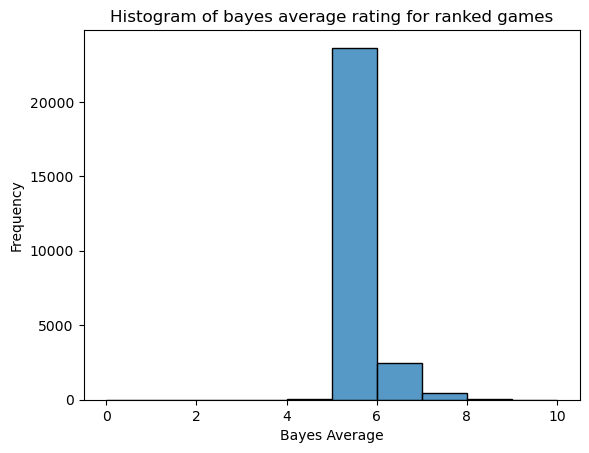

In [48]:
## Only considering games with at least 1 review ##

# Distribution of average rating for ranked games
sns.histplot(rank_df.loc[(rank_df.get('rank')>0)&(rank_df.usersrated > 0),'average'],binrange=(0,10),binwidth=1)
plt.title('Histogram of average rating for ranked games')
plt.xlabel("Average")
plt.ylabel("Frequency")
plt.show()

# Distribution of average rating for non-ranked games
sns.histplot(rank_df.loc[(rank_df.get('rank')==0)&(rank_df.usersrated > 0),'average'],binrange=(0,10),binwidth=1)
plt.title('Histogram of average rating for non-ranked games')
plt.xlabel("Average")
plt.ylabel("Frequency")
plt.show()

# Distribution of bayes average rating for non-ranked games
sns.histplot(rank_df.loc[(rank_df.get('rank')==0)&(rank_df.usersrated > 0),'bayesaverage'],binrange=(0,10),binwidth=1)
plt.title('Histogram of bayes average rating for non-ranked games')
plt.xlabel("Bayes Average")
plt.ylabel("Frequency")
plt.show()

# Distribution of bayes average rating for ranked games
sns.histplot(rank_df.loc[(rank_df.get('rank')>0)&(rank_df.usersrated > 0),'bayesaverage'],binrange=(0,10),binwidth=1)
plt.title('Histogram of bayes average rating for ranked games')
plt.xlabel("Bayes Average")
plt.ylabel("Frequency")
plt.show()



In [49]:
rank_df.loc[(rank_df.get('rank') ==0) & (rank_df.is_expansion ==0)].sort_values('bayesaverage',ascending= False).count()

id                     95877
name                   95877
yearpublished          95877
rank                   95877
bayesaverage           95877
average                95877
usersrated             95877
is_expansion           95877
abstracts_rank             0
cgs_rank                   0
childrensgames_rank        0
familygames_rank           0
partygames_rank            0
strategygames_rank         0
thematic_rank              0
wargames_rank              0
dtype: int64

In [50]:
no_ranks = rank_df.loc[rank_df['rank'] ==0 ,'rank'].count()
yes_ranks = rank_df.loc[(rank_df['rank'] ==0) & (rank_df['usersrated']>=1) ,'rank'].count()


print(f'Percentage of games with a ranking {((yes_ranks/(155634))*100).round(2)} %')


Percentage of games with a ranking 60.53 %


#### Versions, editions, expansions, accessories

In [52]:
# Searching the name column for any mention of the word 'version' explictly:
df_keyword_search(rank_df,'name','version')

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
5743,125048,dobble: free demo version,2013,5744,5.69936,6.42374,801,0,NaN,NaN,223.0,1658.0,NaN,NaN,NaN,NaN
7273,61028,d-day dice: free trial version,2009,7274,5.63087,6.62738,278,0,NaN,NaN,NaN,NaN,NaN,NaN,1035.0,NaN
7455,224303,pocket landship: free trial version,2017,7456,5.62561,7.09540,212,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650.0
11317,356226,exploding kittens: 2-player version,2022,11318,5.55607,6.46682,179,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23926,28508,loaded questions: adult version,2007,23927,5.48930,5.55797,182,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24244,38337,fishing for terrorists version 2.0,2008,24245,5.48659,5.30891,101,0,NaN,NaN,NaN,2990.0,777.0,NaN,NaN,NaN
30825,10106,pocket ungame: couples version,1983,0,0.00000,5.39077,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32108,12033,music buff: pop music version,1989,0,0.00000,5.50000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32400,12442,trivial pursuit the music master game: film & tv edition – video version,1995,0,0.00000,2.25000,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32401,12443,trivial pursuit the music master game: sports edition – video version,1995,0,0.00000,2.66667,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Searching the name column for any mention of the word 'edition' explictly:
df_keyword_search(rank_df,'name','edition')

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
4,233078,twilight imperium: fourth edition,2017,5,8.24195,8.60175,23816,0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN
7,115746,war of the ring: second edition,2011,8,8.18630,8.54238,21354,0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
25,341169,great western trail: second edition,2021,26,7.90004,8.34021,12653,0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN
37,183394,viticulture essential edition,2015,38,7.83834,7.98850,48705,0,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN
41,256960,pax pamir: second edition,2019,42,7.79432,8.19208,14072,0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155488,423540,summoner wars (second edition): the filth faction deck,2024,0,0.00000,0.00000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155490,423543,summoner wars (second edition): chosen grove faction deck,2024,0,0.00000,0.00000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155517,423590,coral sea solitaire: deluxe edition,2024,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155578,423726,league of the lexicon: junior edition,2023,0,0.00000,0.00000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Searching the name column for any mention of the word 'expansion' explictly:
df_keyword_search(rank_df,'name','expansion')

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
1916,345976,system gateway (fan expansion for android: netrunner),2021,1917,6.23147,9.16739,601,0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
3828,241225,smash up: that '70s expansion,2018,3829,5.86071,7.49131,497,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4205,178494,dutch blitz: blue expansion pack,2012,4206,5.81608,7.27618,498,0,NaN,NaN,NaN,NaN,230.0,NaN,NaN,NaN
12492,26004,bitter woods deluxe edition expansion kit,2004,12493,5.54485,7.56667,48,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1936.0
15646,155745,stak bots: yellow expansion,2014,15647,5.52636,6.97872,47,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155383,423291,small city deluxe: arcologies expansion,2024,0,0.00000,0.00000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155408,423343,heroscape: lands of valhalla terrain expansion,2024,0,0.00000,0.00000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155409,423345,heroscape: waters of valhalla terrain expansion,2024,0,0.00000,0.00000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155497,423556,carom golf: garbage expansion,2024,0,0.00000,0.00000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Searching the name column for any mention of the word 'accessories' or 'accessory' explictly:
df_keyword_search(rank_df,'name','accessories')

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
2973,119866,wings of glory: ww1 rules and accessories pack,2012,2974,5.98645,7.97540,628,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.0
8418,131183,wings of glory: ww2 rules and accessories pack,2013,8419,5.60025,7.74950,120,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1179.0
39519,21850,axis & allies: a & a accessories,1995,0,0.00000,6.37500,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115371,293013,blood bowl (2016 edition): head coach's rules & accessories pack,2019,0,0.00000,7.30769,13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Searching the name column for any mention of the word 'accessory' explictly:
df_keyword_search(rank_df,'name','accessory')

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
6785,5985,miscellaneous game accessory,0,6786,5.64903,7.07733,232,0,NaN,NaN,NaN,NaN,NaN,2197.0,NaN,1471.0
29954,8695,speed circuit: accessory pack 1,1980,0,5.52833,7.41765,34,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29955,8696,speed circuit: accessory pack 2,0,0,0.00000,7.31579,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29956,8697,speed circuit: accessory pack 3,0,0,0.00000,7.15000,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29957,8698,speed circuit: accessory pack 4,1991,0,0.00000,7.10526,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32868,13102,entrepreneur's accessory to monopoly (fan expansion for monopoly),1989,0,0.00000,10.00000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47474,31693,miscellaneous miniatures game accessory,0,0,0.00000,6.75294,17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48938,33456,miscellaneous card game accessory,0,0,0.00000,6.32059,17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71575,121924,"dust tactics: building accessory pack – ""warzone tenement""",2012,0,0.00000,7.52353,17,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74770,131996,dust tactics: airfield accessory pack,2013,0,0.00000,7.47222,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Returning a set of single words that come before the word 'edition'
ed_set = set()

# Loop through each name in the DataFrame
for i in rank_df['name']:
    # Check if 'edition' is in the string and find the word before it
    match = re.search(r'(\b\w+\b)\s+edition', i)
    if match:
        # Append the matched word (group 1) to the set
        ed_set.add(match.group(1))

# Number of different single words which come before the word 'edition'
display(len(ed_set))

# The different single words which come before the word 'edition'
display(print(ed_set))

799

{'somerset', 'complete', 'dark', 'book', 'hispania', 'fiction', 'globetrotter', 'holes', 'family', 'american', 'theory', '1995', '60s', 'idiot', 'horde', '2016', 'music', 'tiktok', 'tape', 'grinstead', 'aberdeen', '98', 'cooking', 'trek', 'umbrous', 'world', 'florida', 'shogun', 'imperial', 'seerah', 'bath', 'leicestershire', 'liverpool', 'discovery', '1997', 'sketch', 'mobbing', 'rotlicht', 'parks', 'bachelor', 'ultimate', 'kanto', 'red', 'bowl', 'admiralty', 'apprentice', 'carnage', 'superdeluxe', 'biographies', 'macau', '8', 'trilogy', 'hove', 'renovated', 'wellness', 'space', 'games', 'series', 'mittelalter', 'doctor', 'fussball', 'reviewed', 'pixar', 'order', 'dory', 'bears', 'cat', 'flemish', 'international', 'carols', 'race', 'romance', 'tour', 'nick', 'beatles', 'touring', 'touch', 'horror', 'pantheon', 'ireland', 'midnight', '3', 'day', 'home', 'global', 'chicken', 'popular', 'turbo', 'simpsons', 'd10', 'musket', 'players', 'libre', 'classic', 'kanye', 'masterpiece', 'champion

None

In [58]:
# Adding two columns to rank_df, one which shows the prefix of the game name, and the other showing the total count of these name prefix's:
rank_df['name_prefix'] = rank_df['name'].str.extract(r'^([^:(]+)') # Name_prefix column

rank_df['name_prefix_count'] = rank_df['name_prefix'].map(rank_df['name_prefix'].value_counts()).fillna(1) # Total count of name prefix's

rank_df.sort_values(by = 'name_prefix_count', ascending = False)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
63560,83318,monopoly: isle of arran edition,2010,0,0.0,2.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
127502,332580,monopoly: venetian palazzo las vegas,2014,0,0.0,9.50000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
77013,139856,monopoly: puteaux,2008,0,0.0,5.66667,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
127458,332476,monopoly: circuit paul ricard,2015,0,0.0,4.00000,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
127492,332562,monopoly: new york yankees collectors edition,2006,0,0.0,10.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82872,160747,töff-töff!,0,0,0.0,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,töff-töff!,1.0
82871,160746,bergreise ein neues würfelspiel,0,0,0.0,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bergreise ein neues würfelspiel,1.0
82870,160733,el club de la aventura,0,0,0.0,5.95500,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,el club de la aventura,1.0
34699,15566,an account of peter coddle's visit to new york,1858,0,0.0,5.50000,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,an account of peter coddle's visit to new york,1.0


In [59]:
# Checking for nulls in the new name_prefix column of rank_df
display(null_count(rank_df[['name_prefix']]))
display(rank_df.loc[pd.isna(rank_df['name_prefix'])])

,null counts,% of nulls
name_prefix,10,0.01


,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
9320,128568,(your name here) and the argonauts,2012,9321,5.58338,7.12620,129,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
20609,282587,(may cause) side effects,2019,20610,5.50660,6.22286,35,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
30724,9978,( your name here ) of the jungle,1999,0,0.00000,7.00000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
33524,14052,(t)raumschiff surprise periode 1: das spiel,2004,0,0.00000,4.75000,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
73483,128440,(unnamed wargame),0,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
126334,328544,(ta)aliens,2018,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
140625,372978,(des)memoria,2019,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
141438,375523,(nie)powinieneś,2019,0,0.00000,5.27778,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
141439,375524,(nie)powinieneś 2,2020,0,0.00000,5.85714,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
149576,405872,(nie)powinieneś 3,2022,0,0.00000,4.50000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [60]:
# Filtering rank_df to exclude games which are an edition of the original 
rank_df.loc[(rank_df['yearpublished'].astype(str).str.len() == 4) &
            (rank_df['yearpublished']>0)].\
            sort_values(by = ['name_prefix_count','name_prefix','yearpublished'],ascending = [False,True,True]).\
            drop_duplicates(subset='name_prefix', keep='first').head(10)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
26556,1406,monopoly,1935,26557,4.28826,4.36168,36023,0,NaN,NaN,NaN,3219.0,NaN,NaN,NaN,NaN,monopoly,1278.0
23994,5244,star wars: destroy death star game,1977,23995,5.48874,5.44196,112,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
1350,1540,battletech,1985,1351,6.43944,7.10031,3612,0,NaN,NaN,NaN,NaN,NaN,NaN,318.0,277.0,battletech,471.0
41251,24081,bushido: a batalha de sekigahara,2005,0,0.00000,5.41667,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bushido,309.0
35496,16601,star trek: the invasion of klingon empire,1982,0,0.00000,7.25000,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star trek,309.0
547,146791,shadows of brimstone: city of the ancients,2014,548,6.92988,7.95411,3946,0,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,shadows of brimstone,284.0
167,463,magic: the gathering,1993,168,7.39874,7.57520,39817,0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
26497,2952,trivial pursuit: genus edition,1981,26498,5.22292,5.24480,8117,0,NaN,NaN,NaN,3198.0,879.0,NaN,NaN,NaN,trivial pursuit,262.0
1109,823,the lord of the rings,2000,1110,6.55364,6.73716,15804,0,NaN,NaN,NaN,NaN,NaN,NaN,328.0,NaN,the lord of the rings,200.0
95086,208161,pokémon tcg: jungle expansion,1997,0,0.00000,6.70000,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0


In [61]:
# Exploring a known common example: Monopoly
rank_df.loc[(rank_df['name_prefix']=='monopoly') &
            (rank_df['yearpublished']!=0)]\
            .sort_values(by ='yearpublished',ascending =True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
26556,1406,monopoly,1935,26557,4.28826,4.36168,36023,0,NaN,NaN,NaN,3219.0,NaN,NaN,NaN,NaN,monopoly,1278.0
44925,28638,monopoly: german,1936,0,0.00000,5.36923,26,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
47210,31351,"monopoly: santiago, chile",1950,0,0.00000,5.07500,20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
23227,13154,monopoly: popular edition,1954,23228,5.49424,5.24608,34,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
24863,14459,monopoly: new zealand,1960,24864,5.48015,4.48571,35,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148371,402421,monopoly: dell technologies,2023,0,0.00000,0.00000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
148414,402500,monopoly: teenage mutant ninja turtles mutant mayhem,2023,0,0.00000,5.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
155061,422465,monopoly: the super mario bros. movie edition,2023,0,0.00000,1.75000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0
147548,400026,monopoly: flip edition – fortnite,2023,0,0.00000,4.50000,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monopoly,1278.0


In [62]:
# Exploring a known common example: starwars
rank_df.loc[(rank_df['name_prefix']=='star wars') &
            (rank_df['yearpublished']!=0)]\
            .sort_values(by ='yearpublished',ascending =True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
32379,12415,star wars: the adventures of r2-d2,1977,0,0.00000,3.81852,27,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
57750,54172,star wars: destroy death star game,1977,0,0.00000,4.00000,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
23994,5244,star wars: destroy death star game,1977,23995,5.48874,5.44196,112,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
26433,4845,star wars: escape from death star game,1977,26434,5.33631,4.80921,594,0,NaN,NaN,NaN,3182.0,NaN,NaN,NaN,NaN,star wars,560.0
25215,6792,star wars: hoth ice planet adventure game,1980,25216,5.47438,4.62327,55,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151552,412565,star wars: trench run,2024,0,0.00000,10.00000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
151525,412472,star wars: legion – fifth brother and seventh sister operative expansion,2024,0,0.00000,9.75000,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
1054,387866,star wars: unlimited,2024,1055,6.58029,8.18848,1614,0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0
6662,410655,star wars: bounty hunters,2024,6663,5.65367,7.17073,288,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,star wars,560.0


In [63]:
# Exploring a known common example: magic
rank_df.loc[(rank_df['name_prefix']=='magic') &
            (rank_df['yearpublished']!=0)]\
            .sort_values(by ='yearpublished',ascending =True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
167,463,magic: the gathering,1993,168,7.39874,7.57520,39817,0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
112126,280890,magic: the gathering – limited edition,1993,0,0.00000,7.62500,16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
96970,218386,magic: the gathering – arabian nights,1993,0,5.54909,7.57692,52,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
134345,353507,magic: the gathering – revised edition,1994,0,0.00000,7.40476,21,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
96971,218388,magic: the gathering – antiquities,1994,0,5.54421,7.21667,54,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148799,403359,magic: the gathering universes beyond – doctor who,2023,0,0.00000,8.06818,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
150795,409973,magic: the gathering – lost caverns of ixalan,2023,0,0.00000,7.81250,8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
153647,419395,magic: the gathering – outlaws of thunder junction,2024,0,0.00000,7.12500,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0
152086,414319,magic: the gathering – murders at karlov manor,2024,0,0.00000,6.12500,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,magic,279.0


In [64]:
# Exploring a known common example: pokémon tcg
rank_df.loc[(rank_df['name_prefix']=='pokémon tcg') &
            (rank_df['yearpublished']!=0)]\
            .sort_values(by ='yearpublished',ascending =True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
102696,241908,pokémon tcg: the mystery of the fossils expansion,1997,0,0.0,6.0000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
95088,208164,pokémon tcg: team rocket expansion,1997,0,0.0,7.0625,8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
102697,241909,pokémon tcg: rocket gang expansion,1997,0,0.0,6.0000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
95086,208161,pokémon tcg: jungle expansion,1997,0,0.0,6.7000,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
95087,208162,pokémon tcg: fossil expansion,1997,0,0.0,6.8000,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151054,410664,pokémon tcg: scarlet & violet – 151,2023,0,0.0,9.0000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
151817,413407,pokémon tcg: scarlet & violet – paradox rift,2023,0,0.0,7.5000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
155001,422335,pokémon tcg: scarlet & violet – obsidian flames,2023,0,0.0,8.0000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0
154956,422190,pokémon tcg: scarlet & violet – twilight masquerade,2024,0,0.0,8.6000,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pokémon tcg,198.0


In [65]:
# Exploring a known common example: wingspan
rank_df.loc[(rank_df['name_prefix']=='wingspan') &
            (rank_df['yearpublished']!=0)]\
            .sort_values(by ='yearpublished',ascending =True)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank,name_prefix,name_prefix_count
26,266192,wingspan,2019,27,7.89943,8.04780,93191,0,NaN,NaN,NaN,2.0,NaN,36.0,NaN,NaN,wingspan,5.0
114703,290448,wingspan: european expansion,2019,0,7.93759,8.35031,14933,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wingspan,5.0
114795,290837,wingspan: swift-start promo pack,2019,0,6.50665,7.91667,1625,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wingspan,5.0
139329,368895,wingspan: grus japonensis promo card,2019,0,0.00000,5.46154,13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wingspan,5.0
117701,300580,wingspan: oceania expansion,2020,0,7.89530,8.46814,10273,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wingspan,5.0


## BGG API Board Game Data

### Defining selection of Boardgames to download

#### Filtering dataframe

In [69]:
# Features from the rank_df to retain
features = ['id',
            'name',
            'name_prefix',
            'name_prefix_count',
            'yearpublished',
            'average',
            'bayesaverage',
            'usersrated',
            'is_expansion']

# Filtering the ID's of board games to consider when retrieving data from each board game API
rank_df_filtered = rank_df.loc[(rank_df.average >= 7) & # include games with an average rating of 7 or above
                               (rank_df.usersrated >= 100) & # include games with at least 100 ratings
                               (rank_df.is_expansion == 0), # exclude game expansions, just include base games
                               features].reset_index(drop=True).copy() # resets current index & creates a copy of the DF


In [70]:
# Checking the contents and reduction in the size of the filtered DF:
check_df(rank_df_filtered)

#### DataFrame Dimensions

(4990, 9)

<br>

#### Zero Counts per Column

id                      0
name                    0
name_prefix             0
name_prefix_count       0
yearpublished           7
average                 0
bayesaverage            0
usersrated              0
is_expansion         4990
dtype: int64

<br>

#### Non-Null Counts & Data Types per Column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4990 non-null   int64  
 1   name               4990 non-null   object 
 2   name_prefix        4989 non-null   object 
 3   name_prefix_count  4990 non-null   float64
 4   yearpublished      4990 non-null   int64  
 5   average            4990 non-null   float64
 6   bayesaverage       4990 non-null   float64
 7   usersrated         4990 non-null   int64  
 8   is_expansion       4990 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 351.0+ KB


None

<br>

#### First 10 Rows

,id,name,name_prefix,name_prefix_count,yearpublished,average,bayesaverage,usersrated,is_expansion
0,224517,brass: birmingham,brass,3.0,2018,8.59780,8.41509,45924,0
1,161936,pandemic legacy: season 1,pandemic legacy,3.0,2015,8.52747,8.37995,53515,0
2,174430,gloomhaven,gloomhaven,24.0,2017,8.58904,8.35320,62182,0
3,342942,ark nova,ark nova,3.0,2021,8.53493,8.33425,43527,0
4,233078,twilight imperium: fourth edition,twilight imperium,17.0,2017,8.60175,8.24195,23816,0


<br>

#### Last 10 Rows

,id,name,name_prefix,name_prefix_count,yearpublished,average,bayesaverage,usersrated,is_expansion
4985,387144,r-eco+,r-eco+,1.0,2023,7.36007,5.59732,118,0
4986,391288,firefly: the game – 10th anniversary collector's edition,firefly,29.0,2024,8.90631,5.80830,243,0
4987,405752,project l: collector's edition,project l,8.0,2023,8.20317,5.72265,194,0
4988,406767,hegemony: lead your class to victory – extended edition,hegemony,9.0,2023,8.91737,5.66302,118,0
4989,409858,maple valley: kickstarter edition,maple valley,3.0,2023,7.85937,5.60410,102,0


#### Adding new columns

In [72]:
# Columns to include in rank_df_filtered
columns = ('id',
           'name',
           'name_prefix',
           'name_prefix_count',
           'yearpublished',
           'average',
           'usersrated',
           'number of comments',
           'complexity votes',
           'average complexity',
           'year published',
           'min player number',
           'max player number',
           'min play time',
           'max play time',
           'expected play time',
           'minimum age limit',
           'category',
           'mechanism',
           'game designer',
           'publisher',
            'url')

# Iterating through columns and checks if it is present in rank_df_filtered, 
# if not then if adds the column, with each row filled with empty string values
for col in columns:
    if col not in rank_df_filtered.columns:
        rank_df_filtered[col] = ''

# Remove any unwanted columns
for col in rank_df_filtered.columns:
    if col not in columns:
        rank_df_filtered.drop([col], axis =1, inplace = True)

In [73]:
# Checking new size of rank_df_filtered and if new columns have been added:
check_df(rank_df_filtered)

#### DataFrame Dimensions

(4990, 22)

<br>

#### Zero Counts per Column

id                    0
name                  0
name_prefix           0
name_prefix_count     0
yearpublished         7
average               0
usersrated            0
number of comments    0
complexity votes      0
average complexity    0
year published        0
min player number     0
max player number     0
min play time         0
max play time         0
expected play time    0
minimum age limit     0
category              0
mechanism             0
game designer         0
publisher             0
url                   0
dtype: int64

<br>

#### Non-Null Counts & Data Types per Column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4990 non-null   int64  
 1   name                4990 non-null   object 
 2   name_prefix         4989 non-null   object 
 3   name_prefix_count   4990 non-null   float64
 4   yearpublished       4990 non-null   int64  
 5   average             4990 non-null   float64
 6   usersrated          4990 non-null   int64  
 7   number of comments  4990 non-null   object 
 8   complexity votes    4990 non-null   object 
 9   average complexity  4990 non-null   object 
 10  year published      4990 non-null   object 
 11  min player number   4990 non-null   object 
 12  max player number   4990 non-null   object 
 13  min play time       4990 non-null   object 
 14  max play time       4990 non-null   object 
 15  expected play time  4990 non-null   object 
 16  minimu

None

<br>

#### First 10 Rows

,id,name,name_prefix,name_prefix_count,yearpublished,average,usersrated,number of comments,complexity votes,average complexity,year published,min player number,max player number,min play time,max play time,expected play time,minimum age limit,category,mechanism,game designer,publisher,url
0,224517,brass: birmingham,brass,3.0,2018,8.59780,45924,,,,,,,,,,,,,,,
1,161936,pandemic legacy: season 1,pandemic legacy,3.0,2015,8.52747,53515,,,,,,,,,,,,,,,
2,174430,gloomhaven,gloomhaven,24.0,2017,8.58904,62182,,,,,,,,,,,,,,,
3,342942,ark nova,ark nova,3.0,2021,8.53493,43527,,,,,,,,,,,,,,,
4,233078,twilight imperium: fourth edition,twilight imperium,17.0,2017,8.60175,23816,,,,,,,,,,,,,,,


<br>

#### Last 10 Rows

,id,name,name_prefix,name_prefix_count,yearpublished,average,usersrated,number of comments,complexity votes,average complexity,year published,min player number,max player number,min play time,max play time,expected play time,minimum age limit,category,mechanism,game designer,publisher,url
4985,387144,r-eco+,r-eco+,1.0,2023,7.36007,118,,,,,,,,,,,,,,,
4986,391288,firefly: the game – 10th anniversary collector's edition,firefly,29.0,2024,8.90631,243,,,,,,,,,,,,,,,
4987,405752,project l: collector's edition,project l,8.0,2023,8.20317,194,,,,,,,,,,,,,,,
4988,406767,hegemony: lead your class to victory – extended edition,hegemony,9.0,2023,8.91737,118,,,,,,,,,,,,,,,
4989,409858,maple valley: kickstarter edition,maple valley,3.0,2023,7.85937,102,,,,,,,,,,,,,,,


#### Cleaning filtered dataframe

In [75]:
# Removing all "games" with the name accessory or accessories included
rank_df_filtered.drop(rank_df_filtered[rank_df_filtered.name.str.contains('accessory',case = False)].index,inplace=True)
rank_df_filtered.drop(rank_df_filtered[rank_df_filtered.name.str.contains('accessories',case = False)].index,inplace=True)
rank_df_filtered['id'].count() # Count the number of reduced rows

4987

In [76]:
# Removing all "games" with the name expansion included
rank_df_filtered.drop(rank_df_filtered[rank_df_filtered.name.str.contains('expansion',case = False)].index,inplace=True)
rank_df_filtered['id'].count() # Count the number of reduced rows

4983

In [77]:
# Sorting all the rows by name prefix then year published to show the first instances of the game at the top of the sub section for the name prefix
rank_df_filtered.sort_values(by = ['name_prefix_count','name_prefix','yearpublished'],ascending = [False,True,True]).\
            drop_duplicates(subset='name_prefix', keep='first').head(10)

,id,name,name_prefix,name_prefix_count,yearpublished,average,usersrated,number of comments,complexity votes,average complexity,year published,min player number,max player number,min play time,max play time,expected play time,minimum age limit,category,mechanism,game designer,publisher,url
1022,939,star wars: the queen's gambit,star wars,560.0,2000,7.58684,2255,,,,,,,,,,,,,,,
1222,1540,battletech,battletech,471.0,1985,7.10031,3612,,,,,,,,,,,,,,,
3466,210152,bushido,bushido,309.0,2018,7.25876,249,,,,,,,,,,,,,,,
893,79127,star trek: fleet captains,star trek,309.0,2011,7.47356,3331,,,,,,,,,,,,,,,
547,146791,shadows of brimstone: city of the ancients,shadows of brimstone,284.0,2014,7.95411,3946,,,,,,,,,,,,,,,
167,463,magic: the gathering,magic,279.0,1993,7.57520,39817,,,,,,,,,,,,,,,
2870,28805,the lord of the rings: strategy battle game,the lord of the rings,200.0,2005,7.31857,413,,,,,,,,,,,,,,,
2622,229427,"warhammer 40,000 (eighth edition)","warhammer 40,000",185.0,2017,7.42102,458,,,,,,,,,,,,,,,
673,113924,zombicide,zombicide,178.0,2012,7.09692,18872,,,,,,,,,,,,,,,
4364,39169,"warhammer 40,000: codex","warhammer 40,000",173.0,1994,7.03162,136,,,,,,,,,,,,,,,


In [78]:
# Creating a list of game id's to remove from the dataframe, focusing on expansions or editions that are not the base game

remove_lst=[]
remove_lst =  rank_df_filtered.loc[rank_df_filtered['name_prefix']=='magic','id'].iloc[1:].tolist()
#remove_lst.extend(rank_df_filtered.loc[rank_df_filtered['name_prefix']=='pokemon tcg','id'].iloc[1:].tolist())

# Showing the id's to be removed
remove_lst


[231309, 231392]

In [79]:
# Removing the id's based on the remove_lst from above
rank_df_filtered = rank_df_filtered[~rank_df_filtered['id'].isin(remove_lst)]

# Checking the games intended to be removed are actually removed
rank_df_filtered[rank_df_filtered['id'].isin(remove_lst)]

,id,name,name_prefix,name_prefix_count,yearpublished,average,usersrated,number of comments,complexity votes,average complexity,year published,min player number,max player number,min play time,max play time,expected play time,minimum age limit,category,mechanism,game designer,publisher,url


### Pulling data from BGG Server

#### Testing data retrieval through BGG API

In [82]:
# Checking the output of data retrieved for a specifc board game using the BGG API

test_id = 224517 # Variable specifying a single board game id
link_temp = f'https://boardgamegeek.com/xmlapi2/thing?id={test_id}&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1' # This is the template URL for the API request, accesses data for the specific game id ('test_id')

response = requests.get(link_temp) # Sending request and returning a repsonse object from the BGG server (XML data)
root = ET.fromstring(response.content)  # Parse XML into tree structure

print(link_temp) # URL for API request sent

# Printing game characteristics from the server response for the specified game:
print(f'Title: ',root.find('.//name[@type="primary"]').get('value')) # Primary name of the game
print(f'Number of comments from users: ',root.find('.//numcomments').get('value')) # Number of comments sent as part of ratings
print(f'Year published: ',root.find('.//yearpublished').get('value')) # Year the game was published
print(f'Min number of players:',root.find('.//minplayers').get('value')) # Minimum number of players
print(f'Max number of players: ',root.find('.//maxplayers').get('value')) # Maximum number of players
print(f'Expected playtime: ',root.find('.//playingtime').get('value')) # Expected playtime
print(f'Min playtime: ',root.find('.//minplaytime').get('value')) # Minimum playtime
print(f'Max playtime: ',root.find('.//maxplaytime').get('value')) # Maximum playtime
print(f'Min playing age: ',root.find('.//minage').get('value')) # Minimum playing age
print(f'Number of votes on game complexity: ',root.find('.//numweights').get('value')) # Number of user votes on game complexity
print(f'Average rating of complexity (0=low & 5=high): ',root.find('.//averageweight').get('value')) # Average game complexity rating, 0 = low & 5 = high

# Creating sets for game characteristics with mutliple elements:
test_categories = set() # Contains all associated categories
test_mechanics = set() # Contains all associated mechanics
test_families = set() # Contains all associated families
test_designers = set() # Contains all associated designers
test_publishers = set() # Contains all associated publishers

# Collecting data from the server response and adding entries to each set:
for link in root.findall('.//link[@type="boardgamecategory"]'): # Categories
    test_categories.add(link.get('value'))
    
for link in root.findall('.//link[@type="boardgamemechanic"]'): # Mechanics
    test_mechanics.add(link.get('value'))
    
for link in root.findall('.//link[@type="boardgamedesigner"]'): # Designers
    test_designers.add(link.get('value'))
    
for link in root.findall('.//versions/item/link[@type="boardgamepublisher"]'): # Publishers
    test_publishers.add(link.get('value'))

# Printing game characteristics with multiple elements:
print(f'Categories: ',test_categories) # Categories associated with the game
print(f'Mechanics: ',test_mechanics) # Mechanics associated with the game
print(f'Designers: ',test_designers) # Game designers involved
print(f'Publishers: ',test_publishers) # Game publishers involved

https://boardgamegeek.com/xmlapi2/thing?id=224517&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
Title:  Brass: Birmingham
Number of comments from users:  6569
Year published:  2018
Min number of players: 2
Max number of players:  4
Expected playtime:  120
Min playtime:  60
Max playtime:  120
Min playing age:  14
Number of votes on game complexity:  2282
Average rating of complexity (0=low & 5=high):  3.8751
Categories:  {'Post-Napoleonic', 'Transportation', 'Economic', 'Age of Reason', 'Industry / Manufacturing', 'Trains'}
Mechanics:  {'Market', 'Income', 'Tech Trees / Tech Tracks', 'Variable Set-up', 'Multi-Use Cards', 'Network and Route Building', 'Turn Order: Stat-Based', 'Tags', 'Hand Management', 'Loans'}
Designers:  {'Martin Wallace', 'Gavan Brown', 'Matt Tolman'}
Publishers:  {'Lanlalen', 'Maldito Games', 'Funforge', 'Ghenos Games', 'Roxley', 'BoardM Factory', 'TLAMA games', 'White Goblin Games', 'Conclave Editora', 'Gém Klub Kft.', 'Rebel Sp. z o.o.', 'Board 

#### Full data retrieval through BGG API

In [84]:
# Collecting data on each game specified in the rank_df_filtered table:

start = 0 # Index value in rank_df_filtered corresponding to the game id you want to start pulling data for, 0 if starting anew

# Looping through each row index of rank_df_filtered from a defined 'start' variable to the last row
for i in range(start,len(rank_df_filtered)):
   
    id = rank_df_filtered.loc[i,'id'] # Assigning the variable 'id' with the 'game id' from the current index iteration, this used to select the page of information for a specific game to request from the server
    
    try:
        url = f'https://boardgamegeek.com/xmlapi2/thing?id={id}&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1' # This is the template URL for the API request, accesses data for the specific game 'id'
        response = requests.get(url) # Sending request and returning a repsonse object from the BGG server (XML data)
        root = ET.fromstring(response.content)  # Parse XML into tree structure
        
        # Creating sets for game characteristics with mutliple elements:
        categories = set()
        mechanic = set()
        family = set()
        designer = set()
        publisher = set()
        
        # Updating rank_df_filtered fields with game characteristics from the server response (single elements):
        rank_df_filtered.at[i, 'number of comments'] = root.find('.//numcomments').get('value') # Number of comments
        rank_df_filtered.at[i, 'complexity votes'] = root.find('.//numweights').get('value') # Number of complexity votes
        rank_df_filtered.at[i, 'average complexity'] = root.find('.//averageweight').get('value') # Average complexity rating
        rank_df_filtered.at[i, 'year published'] = root.find('.//yearpublished').get('value') # Year published
        rank_df_filtered.at[i, 'min player number'] = root.find('.//minplayers').get('value') # Minimum number of players
        rank_df_filtered.at[i, 'max player number'] = root.find('.//maxplayers').get('value') # Maximum number of players
        rank_df_filtered.at[i, 'expected play time'] = root.find('.//playingtime').get('value') # Expected playtime
        rank_df_filtered.at[i, 'min play time'] = root.find('.//minplaytime').get('value') # Minimum play time
        rank_df_filtered.at[i, 'max play time'] = root.find('.//maxplaytime').get('value') # Maximum play time
        rank_df_filtered.at[i, 'minimum age limit'] = root.find('.//minage').get('value') # Minimum age limit
        

        # Updating rank_df_filtered fields with game characteristics from the server response (multiple elements):
        for link in root.findall('.//link[@type="boardgamecategory"]'): # Categories
            categories.add(link.get('value'))
        for link in root.findall('.//link[@type="boardgamemechanic"]'): # Mechanics
            mechanic.add(link.get('value'))
        for link in root.findall('.//link[@type="boardgamedesigner"]'): # Designers
            designer.add(link.get('value'))
        for link in root.findall('.//link[@type="boardgamepublisher"]'): # Publishers
            publisher.add(link.get('value'))

        # Convert set to a list with ' // ' separator:
        rank_df_filtered.at[i, 'category'] = ' // '.join(categories) # Categories
        rank_df_filtered.at[i, 'mechanism'] = ' // '.join(mechanic) # Mechanics
        rank_df_filtered.at[i, 'game designer'] = ' // '.join(designer) # Designers
        rank_df_filtered.at[i, 'publisher'] = ' // '.join(publisher) # Publishers

        # Updating the rank_df_filtered URL field showing the URL used to access the BGG server for the specific game:
        rank_df_filtered.at[i, 'url'] = url
        
        # Live status on progress of game data extraction from BGG server:
        id_count = len(rank_df_filtered) # Total number of game id's that will iterated through for each server request
        start=start+1 # Off-setting the start count by 1 to show the 1st server request as the number 1 not 0
        time.sleep(5)  # Adding a delay of 5 seconds before retrying the server request for the next game
        current_timestamp = datetime.now().strftime("%d-%m %H:%M:%S") #  # Get the current date and time and format it as "day-month hour:minute:second"
        print(f'\rid {id} - Progress = {i+1} / {id_count} - Timestamp: {current_timestamp}', end='') # Printing the current progress of data extraction, including: the current game ID, progress count, and timestamp

    
    except AttributeError as e: # Exception handling for elements that do not exist
        
        print(f"AttributeError for id {id}: {e}") # printing the specific game id and error description
        
        continue  # Skip to the next iteration

id 220308 - Progress = 12 / 4981 - Timestamp: 16-09 09:09:35

KeyboardInterrupt: 

#### Data Validation

In [ ]:
# Check contents of the newly added data to rank_df_filtered
check_df(rank_df_filtered)

#### Saving the dataframe

In [ ]:
# Saving the data to csv, left commented to ensure Board_games_filtered.csv is not overwritten in new session
# rank_df_filtered.to_csv('Board_games_filtered.csv', index=False) 

### BGG Boardgame Data EDA

#### Loading in saved dataframe

In [10]:
# Creating dataframe from Board_games_filtered.csv data
saved_df = pd.read_csv('Board_games_filtered.csv')

In [12]:
# Check contents of saved_df to see if it has loaded correctly 
check_df(saved_df)

#### DataFrame Dimensions

(4981, 19)

<br>

#### Zero Counts per Column

id                      0
name                    0
average                 0
usersrated              0
number of comments      0
complexity votes        4
average complexity      4
year published          6
min player number       4
max player number       8
min play time          20
max play time          27
expected play time     27
minimum age limit     254
category                0
mechanism               0
game designer           0
publisher               0
url                     0
dtype: int64

<br>

#### Non-Null Counts & Data Types per Column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4981 non-null   int64  
 1   name                4981 non-null   object 
 2   average             4981 non-null   float64
 3   usersrated          4981 non-null   int64  
 4   number of comments  4981 non-null   int64  
 5   complexity votes    4981 non-null   int64  
 6   average complexity  4981 non-null   float64
 7   year published      4981 non-null   int64  
 8   min player number   4981 non-null   int64  
 9   max player number   4981 non-null   int64  
 10  min play time       4981 non-null   int64  
 11  max play time       4981 non-null   int64  
 12  expected play time  4981 non-null   int64  
 13  minimum age limit   4981 non-null   int64  
 14  category            4941 non-null   object 
 15  mechanism           4937 non-null   object 
 16  game d

None

<br>

#### First 10 Rows

,id,name,average,usersrated,number of comments,complexity votes,average complexity,year published,min player number,max player number,min play time,max play time,expected play time,minimum age limit,category,mechanism,game designer,publisher,url
0,224517,Brass: Birmingham,8.59780,45924,6508,2269,3.8775,2018,2,4,60,120,120,14,Economic // Post-Napoleonic // Trains // Age of Reason // Transportation // Industry / Manufacturing,Loans // Network and Route Building // Market // Hand Management // Tech Trees / Tech Tracks // Turn Order: Stat-Based // Variable Set-up // Tags // Income,Matt Tolman // Gavan Brown // Martin Wallace,Funforge // BoardM Factory // Lanlalen // Gém Klub Kft. // CMON Global Limited // 盒拍工作室 Hepa Studio // Rebel Sp. z o.o. // Ghenos Games // Lord of Boards // Arclight Games // Conclave Editora // Dexker Games // Maldito Games // TLAMA games // PHALANX // Giant Roc // Board Game Rookie // White Goblin Games // Roxley // CrowD Games,https://boardgamegeek.com/xmlapi2/thing?id=224517&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
1,161936,Pandemic Legacy: Season 1,8.52747,53515,8031,1467,2.8303,2015,2,4,60,60,60,13,Medical // Environmental,Variable Player Powers // Cooperative Game // Hand Management // Action Points // Scenario / Mission / Campaign Game // Legacy Game // Point to Point Movement // Set Collection // Trading // Tags,Matt Leacock // Rob Daviau,Z-Man Games // Lifestyle Boardgames Ltd // Hobby Japan // Devir // Korea Boardgames // Asterion Press // Gém Klub Kft. // Jolly Thinkers // Ігромаг // MINDOK // Filosofia Éditions // Lacerta,https://boardgamegeek.com/xmlapi2/thing?id=161936&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
2,174430,Gloomhaven,8.58904,62182,10902,2584,3.9129,2017,1,4,60,120,120,14,Fighting // Miniatures // Adventure // Fantasy // Exploration,Communication Limits // Variable Player Powers // Cooperative Game // Simultaneous Action Selection // Critical Hits and Failures // Legacy Game // Tags // Campaign / Battle Card Driven // Deck Construction // Solo / Solitaire Game // Action Queue // Narrative Choice / Paragraph // Card Play Conflict Resolution // Line of Sight // Action Retrieval // Hexagon Grid // Role Playing // Hand Management // Scenario / Mission / Campaign Game // Multi-Use Cards // Modular Board // Grid Movement // Once-Per-Game Abilities,Isaac Childres,"Games Warehouse // MYBG Co., Ltd. // Arclight Games // Albi Polska // Feuerland Spiele // Korea Boardgames // Galápagos Jogos // Gém Klub Kft. // Hobby World // Cephalofair Games // Albi",https://boardgamegeek.com/xmlapi2/thing?id=174430&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
3,342942,Ark Nova,8.53493,43527,5908,2361,3.7662,2021,1,4,90,150,150,14,Economic // Animals // Environmental,Open Drafting // Variable Player Powers // Variable Set-up // Hand Management // Increase Value of Unchosen Resources // Grid Coverage // End Game Bonuses // Solo / Solitaire Game // Race // Hexagon Grid // Tile Placement // Set Collection // Action Queue // Tags // Income,Mathias Wigge,Capstone Games // テンデイズゲームズ(TendaysGames) // Gém Klub Kft. // MINDOK // Grok Games // CMON Global Limited // MIPL // Game Harbor // Korea Boardgames // Tower Tactic Games // Cranio Creations // Ludofy Creative // Maldito Games // Super Meeple // White Goblin Games // Feuerland Spiele // Portal Games // Regatul Jocurilor // IGAMES // Lautapelit.fi,https://boardgamegeek.com/xmlapi2/thing?id=342942&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
4,233078,Twilight Imperium: Fourth Edition,8.60175,23816,3594,1186,4.3187,2017,3,6,240,480,480,14,Economic // Space Exploration // Political // Wargame // Negotiation // Civilization // Exploration // Science Fiction,Movement Points // Variable Player Powers // Action Drafting // Follow // Increase Value of Unchosen Resources // Tech Trees / Tech Tracks // Race // Voting // Hexagon Grid // Modular Board // Area-Impulse // Variable Phase Order 

<br>

#### Last 10 Rows

,id,name,average,usersrated,number of comments,complexity votes,average complexity,year published,min player number,max player number,min play time,max play time,expected play time,minimum age limit,category,mechanism,game designer,publisher,url
4976,387144,R-ECO+,7.36007,118,34,4,1.750,2023,2,4,30,30,30,10,Environmental // Card Game // Bluffing,Open Drafting // Hand Management,Susumu Kawasaki,Hobby Japan,https://boardgamegeek.com/xmlapi2/thing?id=387144&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
4977,391288,Firefly: The Game – 10th Anniversary Collector's Edition,8.90631,243,126,8,3.125,2024,1,10,120,240,240,13,Travel // Space Exploration // Adventure // Movies / TV / Radio theme // Science Fiction,Variable Player Powers // Pick-up and Deliver // Area Movement // Solo / Solitaire Game // Take That // Dice Rolling // Open Drafting // Trading,Joe Kepler // George Krubski // Sean Sweigart // Aaron Dill,"Gale Force Nine, LLC",https://boardgamegeek.com/xmlapi2/thing?id=391288&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
4978,405752,Project L: Collector's Edition,8.20317,194,47,2,1.500,2023,1,6,20,40,40,13,Abstract Strategy // Video Game Theme // Puzzle,Open Drafting // Action Points // Pattern Building // Tile Placement,Michal Mikeš // Adam Španěl // Jan Soukal // Filip Daňhel,Boardcubator,https://boardgamegeek.com/xmlapi2/thing?id=405752&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
4979,406767,Hegemony: Lead Your Class to Victory – Extended Edition,8.91737,118,36,10,4.200,2023,1,4,90,180,180,14,Economic // Educational // Negotiation // Political,"Variable Player Powers // Hand Management // Action/Event // Simulation // Roles with Asymmetric Information // Voting // Worker Placement, Different Worker Types",Varnavas Timotheou // Vangelis Bagiartakis,Giant Roc // BoardM Factory // Fox in the Box // Galápagos Jogos // Bumble3ee Interactive // Hegemonic Project Games // Ігромаг // Don't Panic Games // MINDOK,https://boardgamegeek.com/xmlapi2/thing?id=406767&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1
4980,409858,Maple Valley: Kickstarter Edition,7.85937,102,33,4,1.750,2023,1,5,60,60,60,8,Animals,Set Collection // Hand Management // Kill Steal,Roberta Taylor,Gen-X Games // Matagot // Kids Table BG // Lucrum Games,https://boardgamegeek.com/xmlapi2/thing?id=409858&type=boardgame&versions=1&stats=1&marketplace=1&ratingcomments=1


#### Metadata

##### id
This is the identification number given by Board Game Geek to each game

##### name  
This is the name of the game.

##### Average
The average user rating, based on individual ratings out of 10.

##### usersrated
This is the number of people who have rated the game.

##### number of comments  
This is the number of people who have sent a comment with their rating about the game on the website

##### complexity votes  
This the total number of people who have voted on the complexity of the game

##### average complexity  
The average user rating, based on individual ratings out of 5, 0 being the lowest complexity and 5 being the highest

##### year published  
The year the game was published

##### min player number  
The minimum number of players of the game as recorded by Board Game Geek

##### max player number  
The maximum number of players of the game as recorded by Board Game Geek

##### min play time  
The minimum play time of the game in minutes

##### max play time  
The maximum play time of the game in minutes

##### expected play time  
This is the expected play time of the game in minutes

##### minimum age limit  
This is the minimum age limit for the game

##### category  
These are groupings for a games based on similar subjects or characteristics

##### mechanism  
These are groupings for games based more specifically on the types of action performed in game by a player that modifies the game state

##### game designer 
These are the individuals or groups that responsible for the creative vision, concept, and overall design
 
##### publisher
These are the groups responsible for financing, marketing, distributing the game
##### url
This is the URL of the API server used to access the source of data from the Board Game Geek server for the specific game l  

#### Null counts

In [ ]:
null_count(saved_df)

#### Zero counts

In [ ]:
# Shows a breakdown of zero counts and percentage of zero counts per column
zero_count(saved_df)

#### Numerical values

In [ ]:
# Checking statistical summary of the numerical values in saved_df (excluding id)
saved_df.loc[:,['year published','average','usersrated','average complexity','complexity votes','number of comments','min player number','max player number','min play time','max play time','expected play time']].describe()

#### Complexity votes & average

In [ ]:
# Checking the top and lower 5 games in the saved_df ordered by highest complexity
display(saved_df.sort_values(by = 'average complexity', ascending = False).head(5))
display(saved_df.sort_values(by = 'average complexity', ascending = False).tail(5))

In [ ]:
# Viewing the distribution of average complexity per game (between 0 and 5)
sns.histplot(saved_df['average complexity'])
plt.title('Histogram of average complexity per game')
plt.xlabel("Average complexity")
plt.ylabel("Frequency")
plt.show()

# Viewing the distribution of complexity votes per game
sns.histplot(saved_df['complexity votes'])
plt.title('Histogram of complexity votes per game')
plt.xlabel("Number of complexity votes")
plt.ylabel("Frequency")
plt.show()

In [129]:
# Sorting the complexity votes from highest to lowest
saved_df.sort_values(by = 'complexity votes', ascending =False, inplace=True)

# Exploring the number of complexity votes per game number of games with no ratings
print(f"Number of games with no complexity votes given: {saved_df.loc[(saved_df['complexity votes'] == 0), 'complexity votes'].count()}")

# Exploring the number of complexity votes per game number of games with less than 10 ratings
print(f"Number of games with less than 10 complexity votes given: {saved_df.loc[(saved_df['complexity votes'] < 10), 'complexity votes'].count()}")

# Median complexity votes per game
print(f"Median complexity votes given: {saved_df.loc[:,'complexity votes'].median()}")

# 95th percentile of complexity votes
complexity_votes_95th = np.percentile(saved_df.loc[:,'complexity votes'].values, 95)
print(f"95th Percentile of complexity votes: {complexity_votes_95th}")  

# Count of games above 95th percentile of complexity votes
print(f"Count of games above 95th Percentile of complexity votes: {saved_df.loc[(saved_df['complexity votes'] >complexity_votes_95th), 'complexity votes'].count()}")  

# Count of games above 95th percentile of complexity votes
print(f"Count of games in and below 95th Percentile of complexity votes: {saved_df.loc[(saved_df['complexity votes'] <=complexity_votes_95th), 'complexity votes'].count()}")  


Number of games with no complexity votes given: 4
Number of games with less than 10 complexity votes given: 925
Median complexity votes given: 30.0
95th Percentile of complexity votes: 652.0
Count of games above 95th Percentile of complexity votes: 249
Count of games in and below 95th Percentile of complexity votes: 4732


In [ ]:
# Viewing the distribution of complexity votes per game below 95th percentile
sns.histplot(saved_df.loc[saved_df['complexity votes']<complexity_votes_95th,'complexity votes'])
plt.title('Histogram of complexity votes per game below 95th percentile')
plt.xlabel("Number of complexity votes")
plt.ylabel("Frequency")
plt.show()

In [16]:
# Identifying the games with no complexity average
saved_df.loc[saved_df['average complexity']==0,['id','name','complexity votes','average complexity']]

,id,name,complexity votes,average complexity
3805,331953,Unlock!: Timeless Adventures – Verloren im Zeitstrudel!,0,0.0
4049,327913,Unlock!: Timeless Adventures – Arsène Lupin und der große weiße Diamant,0,0.0
4483,202096,Marvel Dice Masters: Iron Man and War Machine Starter Set,0,0.0
4944,347747,Mythic Mischief: Headmaster's Box,0,0.0


#### Player numbers

In [ ]:
# Checking the top and lower 5 games in the saved_df ordered by max number of players
display(saved_df.sort_values(by = 'max player number', ascending = False).head(5))
display(saved_df.sort_values(by = 'max player number', ascending = False).tail(5))

In [ ]:
# Viewing the distribution of max number of players per game
sns.histplot(saved_df['max player number'])
plt.title('Histogram of max player numbers per game')
plt.xlabel("Max player number")
plt.ylabel("Frequency")
plt.show()

# Viewing the distribution of min number of players per game
sns.histplot(saved_df['min player number'])
plt.title('Histogram of min players number per game')
plt.xlabel("Min player number")
plt.ylabel("Frequency")
plt.show()

In [41]:
# Sorting the max player number from highest to lowest
saved_df.sort_values(by = 'max player number', ascending =False, inplace=True)

# Exploring the number of games with no max player number
print(f"Number of games with no max player number given: {saved_df.loc[(saved_df['max player number'] == 0), 'max player number'].count()}")

# Exploring the number of games with no min player number
print(f"Number of games with no min player number given: {saved_df.loc[(saved_df['max player number'] == 0), 'max player number'].count()}")

# Exploring the number of games with max player number more than 12 players
print(f"Number of games with more than 12 max player number given: {saved_df.loc[(saved_df['max player number'] > 12), 'max player number'].count()}")

# Exploring the number of games with max player number more than 99 players
print(f"Number of games with more than 99 max player number given: {saved_df.loc[(saved_df['max player number'] > 99), 'max player number'].count()}")

# Median max player number per game
print(f"Median max player number given: {saved_df.loc[:,'max player number'].median()}")

# 95th percentile of max player number
max_player_number_95th = np.percentile(saved_df.loc[:,'max player number'].values, 95)
print(f"95th Percentile of max player number: {max_player_number_95th}")  

# Count of games above 95th percentile of max player number
print(f"Count of games above 95th Percentile of max player number: {saved_df.loc[(saved_df['max player number'] >max_player_number_95th), 'max player number'].count()}")  

# Count of games above 95th percentile of max player number
print(f"Count of games in and below 95th Percentile of max player number: {saved_df.loc[(saved_df['max player number'] <=max_player_number_95th), 'max player number'].count()}")  

Number of games with no max player number given: 8
Number of games with no min player number given: 8
Number of games with more than 12 max player number given: 69
Number of games with more than 99 max player number given: 13
Median max player number given: 4.0
95th Percentile of max player number: 8.0
Count of games above 95th Percentile of max player number: 163
Count of games in and below 95th Percentile of max player number: 4818


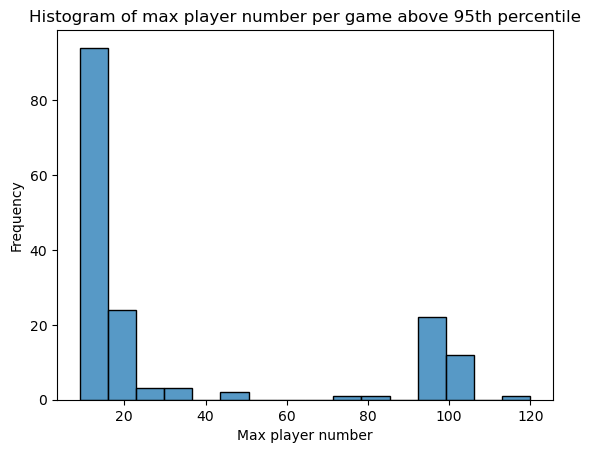

In [61]:
# Viewing the distribution of max number of players per game within the 95th percentile
sns.histplot(saved_df.loc[saved_df['max player number'] > max_player_number_95th,'max player number'])
plt.title('Histogram of max player number per game above 95th percentile')
plt.xlabel("Max player number")
plt.ylabel("Frequency")
plt.show()

In [63]:
# Identifying the games with 12 or more max player numbers
saved_df.loc[saved_df['max player number']>12,['id','name','min player number','max player number']]

,id,name,min player number,max player number
3848,60815,Black Powder: Second Edition,2,120
2319,360471,Aquamarine,1,100
147,263918,Cartographers,1,100
4523,390903,Villagers of the Oak Dell,1,100
2075,298586,Demeter,1,100
4266,362121,Sunshine City,1,100
1411,350736,Voyages,1,100
4912,322045,Cartographers Heroes: Collector's Edition,1,100
3442,330664,Varuna,1,100
468,315767,Cartographers Heroes,1,100


#### Playtime

In [ ]:
# Checking the top and lower 5 games in the saved_df ordered by Max playtime
display(saved_df.sort_values(by = 'max play time', ascending = False).head(5))
display(saved_df.sort_values(by = 'max play time', ascending = False).tail(5))

In [65]:
# Sorting the max play time from highest to lowest
saved_df.sort_values(by = 'max play time', ascending =False, inplace=True)

# Exploring the number of games with no max play time
print(f"Number of games with no max play time given: {saved_df.loc[(saved_df['max play time'] == 0), 'max play time'].count()}")

# Exploring the number of games with no min play time
print(f"Number of games with no min play time given: {saved_df.loc[(saved_df['min play time'] == 0), 'min play time'].count()}")  

# Exploring the number of games with no expected play time
print(f"Number of games with no expected play time given: {saved_df.loc[(saved_df['expected play time'] == 0), 'expected play time'].count()}\n")

# Checking if the games with zero values for expected play time are the same games as those with zero values for max play time
print(f"Are the games with zero expected play time and zero max play time the same?: {saved_df.loc[saved_df['expected play time'] ==0].equals( saved_df.loc[saved_df['max play time'] ==0])}")

# Exploring the number of games with no expected play time
print(f"Do games with expected play time and max play time have the same value?: {saved_df['expected play time'].equals(saved_df['max play time'])} \n")

# Exploring the number of games with max play time more than 120 minutes
print(f"Number of games with more than 120 minutes of max play time given: {saved_df.loc[(saved_df['max play time'] > 120), 'max play time'].count()}")

# Exploring the number of games with expected play time more than max play time
print(f"Number of games with expected play time more than max play time given: {saved_df.loc[(saved_df['expected play time']-saved_df['max play time'])<0, 'max play time'].count()}")

# Median max play time per game
print(f"Median max play time given: {saved_df.loc[:,'max play time'].median()}\n")

# 95th percentile of max play time
max_play_time_95th = np.percentile(saved_df.loc[:,'max play time'].values, 95)
print(f"95th Percentile of max play time: {max_play_time_95th}")  

# Count of games above 95th percentile of max play time
print(f"Count of games above 95th Percentile of max play time: {saved_df.loc[(saved_df['max play time'] > max_play_time_95th), 'max play time'].count()}")  

# Count of games above 95th percentile of max play time
print(f"Count of games in and below 95th Percentile of max play time: {saved_df.loc[(saved_df['max play time'] <= max_play_time_95th), 'max play time'].count()}")  

Number of games with no max play time given: 27
Number of games with no min play time given: 20
Number of games with no expected play time given: 27

Are the games with zero expected play time and zero max play time the same?: True
Do games with expected play time and max play time have the same value?: True 

Number of games with more than 120 minutes of max play time given: 1146
Number of games with expected play time more than max play time given: 0
Median max play time given: 80.0

95th Percentile of max play time: 360.0
Count of games above 95th Percentile of max play time: 228
Count of games in and below 95th Percentile of max play time: 4753


In [ ]:
# Viewing the distribution of max play time per game
sns.histplot(saved_df['max play time'], binwidth=30)
plt.title('Histogram of max play time per game')
plt.xlabel("Max play time (minutes)")
plt.ylabel("Frequency")
plt.show()

# Viewing the distribution of max play time per game below the 95th percentile
sns.histplot(saved_df.loc[saved_df['max play time']<max_play_time_95th,'max play time'], binrange=(0,max_play_time_95th),binwidth = 30)
plt.title('Histogram of max play time per game below 95th percentile')
plt.xlabel("Max play time (minutes)")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,max_play_time_95th,30))
plt.show()

In [211]:
# Viewing all the games with zero min, max and expected playtime
saved_df.loc[(saved_df['max play time']==0)|(saved_df['min play time']==0)|(saved_df['expected play time']==0),['id','name','min play time','max play time','expected play time']]

,id,name,min play time,max play time,expected play time
448,171,Chess,0,0,0
1222,1540,BattleTech,0,0,0
641,242705,Aeon Trespass: Odyssey,90,0,0
1212,296108,Terraforming Mars: The Dice Game,45,0,0
1027,313889,Hoplomachus: Victorum,0,90,90
2696,29285,Case Blue,0,0,0
2803,17651,Under the Lily Banners,0,0,0
1360,369646,Disney Lorcana,0,0,0
2897,142889,Enemy Coast Ahead: Operation Chastise – The Dambuster Raid,0,0,0
3911,46669,1914: Offensive à outrance,0,0,0


#### Minimum age

In [ ]:
# Checking the top and lower 5 games in the saved_df ordered by minimum age limit
display(saved_df.sort_values(by = 'minimum age limit', ascending = False).head(5))
display(saved_df.sort_values(by = 'minimum age limit', ascending = False).tail(5))

In [267]:
# Exploring the number of games with no minimum age limit
print(f"Number of games with no minimum age limit given: {saved_df.loc[(saved_df['minimum age limit'] == 0), 'minimum age limit'].count()}")


# Exploring the highest value of minimum age limit
print(f"The highest value of the minimum age limit given: {saved_df['minimum age limit'].max()}")

Number of games with no minimum age limit given: 254
The highest value of the minimum age limit given: 21


In [ ]:
# Viewing the distribution of minimum age limit per game
sns.histplot(saved_df['minimum age limit'],binwidth = 1)
plt.title('Histogram of minimum age limit per game')
plt.xlabel("Minimum age limit")
plt.ylabel("Frequency")
plt.show()

#### Category

In [ ]:
# Viewing a sample of the game categories as shown in the saved_df
saved_df[['id','name','category']].head(5)

In [ ]:
# Checking the frequency of each unique category
count_words(saved_df,'category')

In [ ]:
# Checking games with null value in category field
saved_df.loc[saved_df['category'].isna()]

In [ ]:
# Checking the categories for key words: 'expansion', 'version', 'edition' to identify any further non-base games to remove
display(df_keyword_search(saved_df,'category','expansion')[['id','name','category']])
display(df_keyword_search(saved_df,'category','version')[['id','name','category']])
display(df_keyword_search(saved_df,'category','edition')[['id','name','category']])

#### Mechanism

In [ ]:
# Viewing a sample of the game mechanisms as shown in the saved_df
saved_df[['id','name','mechanism']].head(5)

In [ ]:
# Checking games with null value in mechanism field
saved_df.loc[saved_df['mechanism'].isna()]

In [ ]:
# Checking the frequency of each unique mechanism
count_words(saved_df,'mechanism')

#### Game Designer

In [ ]:
# Viewing a sample of the game designers as shown in the saved_df
saved_df[['id','name','game designer']].head(5)

In [ ]:
# Checking games with null value in game designer field
saved_df.loc[saved_df['game designer'].isna()]

In [ ]:
# Checking the frequency of each unique game designer
count_words(saved_df,'game designer')

#### Publisher

In [ ]:
# Viewing a sample of the publishers as shown in the saved_df
saved_df[['id','name','publisher']].head(5)

In [ ]:
# Checking the frequency of each unique publisher
count_words(saved_df,'publisher')

### BGG Boardgame Data Cleaning

#### Creating dataframe copy for cleaning

In [308]:
# Creating a copy of saved_df safeguard against data loss from any mistakes whilst cleaning the data
clean_df = saved_df.copy()

#### Null values

In [193]:
# Checking the null values
null_count(clean_df)

,null counts,% of nulls
id,0,0.00
name,0,0.00
average,0,0.00
usersrated,0,0.00
number of comments,0,0.00
complexity votes,0,0.00
average complexity,0,0.00
year published,0,0.00
min player number,0,0.00
max player number,0,0.00


In [38]:
# Removed all games with null values in columns category, mechanism or game designer
clean_df.dropna(subset=['category','mechanism','game designer'], inplace=True)

# Checking games with null values in these columns have been removed
null_count(clean_df)

,null counts,% of nulls
id,0,0.0
name,0,0.0
average,0,0.0
usersrated,0,0.0
number of comments,0,0.0
complexity votes,0,0.0
average complexity,0,0.0
year published,0,0.0
min player number,0,0.0
max player number,0,0.0


#### Updating complexity values

Complexity votes and average  

Missing at random, each example below is a version or edition of an existing game or games, will take an average from previous similar entries of game series.
- 331953 Unlock!: Timeless Adventures – Verloren im Zeitstrudel! - 2.14
- 327913 Unlock!: Timeless Adventures – Arsène Lupin und der große weiße Diamant - 2.14
- 202096 Marvel Dice Masters: Iron Man and War Machine Starter Set - 2.45
- 347747 Mythic Mischief: Headmaster's Box - 2.89

In [161]:
# Calculating average values based on other games which match with a specific search term, excluding games with zero values
game_input = "Unlock!:"

# Average complexity from other similar games
round(search_and_average(clean_df,"name",game_input,"average complexity"),2)

2.14

In [310]:
# Updating games in clean_df with no complexity rating, using average of other similar games

clean_df.loc[clean_df['id']==331953, ['average complexity']] = 2.14
clean_df.loc[clean_df['id']==327913, ['average complexity']] = 2.14
clean_df.loc[clean_df['id']==202096, ['average complexity']] = 2.45
clean_df.loc[clean_df['id']==347747 , ['average complexity']] = 2.89

In [195]:
# Checking average complexity values have been updated
clean_df.loc[clean_df['id'].isin([331953,327913,202096,347747]),['id','name','average complexity']]

,id,name,average complexity
4944,347747,Mythic Mischief: Headmaster's Box,2.89
4483,202096,Marvel Dice Masters: Iron Man and War Machine Starter Set,2.45
3805,331953,Unlock!: Timeless Adventures – Verloren im Zeitstrudel!,2.14
4049,327913,Unlock!: Timeless Adventures – Arsène Lupin und der große weiße Diamant,2.14


#### Updating player number values

Min & max player numbers missing  

Revised values are quoted below (min - max), first based on BGG or publisher website, then game box (if shown), then based on BGG community:
- 37301 Decktet 1 - 1 (website)
- 248641 Monsterpocalypse Miniatures Game 2 - 2 (website)
- 1585 Burma: The Campaign in Northern Burma, 1 - 3 (website)
- 62214 Aspern-Essling 1809 1 - 2 (community)
- 150012 No Retreat!: Polish & French Fronts 2 - 2 (community) 1944
- 135796 Next War:  1- 2 (community)Taiwan
- 85204 Kings 2 - 2 (website) of War
- 170669 Old School Tactical: Volume 1 - Fighting on the Eastern Front 1 - 2 (community) 1941/42
- 163097 Beyond the Rhine: The Campaign for Northwe 1 - 3 (website)st Europe
- 278373 Twisty Littl 1 - 1 (community)e Passages

In [326]:
zero_min_max_players_ids = clean_df.loc[(clean_df['max player number']==0)|(clean_df['min player number']==0),'id'].tolist()

In [314]:
# Updating games in clean_df with missing min and max player numbers
clean_df.loc[clean_df['id']==37301, ['min player number','max player number']] = [1,1]
clean_df.loc[clean_df['id']==248641, ['min player number','max player number']] = [2,2]
clean_df.loc[clean_df['id']==1585, ['min player number','max player number']] = [1,3]
clean_df.loc[clean_df['id']==62214, ['min player number','max player number']] = [1,2]
clean_df.loc[clean_df['id']==150012, ['min player number','max player number']] = [2,2]
clean_df.loc[clean_df['id']==135796, ['min player number','max player number']] = [1,2]
clean_df.loc[clean_df['id']==85204, ['min player number','max player number']] = [2,2]
clean_df.loc[clean_df['id']==170669, ['min player number','max player number']] = [1,2]
clean_df.loc[clean_df['id']==163097, ['min player number','max player number']] = [1,3]
clean_df.loc[clean_df['id']==278373, ['min player number','max player number']] = [1,1]

In [328]:
# Checking min and max player values have been updated
clean_df.loc[clean_df['id'].isin(zero_min_max_players_ids),['id','name','min player number','max player number']]

,id,name,min player number,max player number


Extreme Player numbers (greater than 12 players)

Revised values are quoted below (max), first based on BGG or publisher website, then game box (if shown), then based on BGG community:

- 60815 Black Powder: Second Edition - 6 (community)
- 298586 Demeter - 6 (community)
- 360471 Aquamarine - 8 (community)
- 319604 Ricochet: A la poursuite du Comte courant - 3 (community)
- 330664 Varuna - 4 (community)
- 390903 Villagers of the Oak Dell - 4 (community)
- 322045 Cartographers Heroes: Collector's Edition - 100 (website)
- 362121 Sunshine City - 100 (website)
- 388329 Waypoints - 100 (website)
- 263918 Cartographers - 100 (website)
- 233867 Welcome To... - 100 (website)
- 315767 Cartographers Heroes - 100 (website)
- 350736 Voyages - 100 (website)
- 308565 Roll n Cook - 99 (website)
- 245389 Word Slam Family - 99 (website)
- 208754 Wings of Glory: Tripods & Triplanes - 99 (website)
- 302344 Scooby-Doo: Escape from the Haunted Mansion - 5 (community)
- 236370 Blood Red Skies: Battle of Britain - 6 (community)
- 317434 Exit: The Game – Advent Calendar: The Mystery of the Ice Cave - 3 (community)
- 378833 Happy Campers - 4 (community)
- 343322 Exit: The Game – Advent Calendar: The Hunt for the Golden Book - 3 (community)
- 51 Ricochet Robots - 2 (community)
- 30618 Eat Poop You Cat - 13 (community)
- 139771 Star Trek: Attack Wing - 6 (community)
- 286428 Wits & Wagers: It's Vegas, Baby! - 21 (community)
- 186279 Finska Mini - 6 (community)
- 155689 Dungeons4  & Dragons: Attack Wing - (community)
- 4985 Warmaster - 3 (community)
- 233194 Banned Words - 8 (community)
- 122913 Samurai Battles - 2 (community)
- 216710 Wings of Glory: WW2 Battle of Britain Starter Set - 4 (website)
- 304620 World of Tanks Miniatures Game - 4 (community)
- 210295 Lightseekers - 5 (community)
- 18615 Warmaster Ancients - 10 (community)
- 297234 Taskmaster: The Board Game - 6 (community)
- 362164 Pioneer Rails - 80 (website)
- 152242 Ultimate Werewolf: Deluxe Edition - 75 (website)
- 344415 Trek 12: Amazonia - 50 (box)
- 168680 The Werewolves of Miller's Hollow: The Pact - 18 (box)
- 59335 Wherewolf - 24 (community)
- 22303 Celebrities - 12 (community)
- 3553 Close Action: The Age of Fighting Sail Vol. 1 - 20 (website)
- 235113 30 Seconds: Everyday Life - 12 (community)
- 236475 The Werewolves of Miller's Hollow: Best Of - 18 (box)
- 311920 Ultimate Werewolf: Extreme - 25 (website)
- 164236 Witch Hunt - 22 (website)
- 240980 Blood on the Clocktower - 20 (website)
- 283152 Monikers: Serious Nonsense - 16 (box)
- 10501	Canvas Eagles: War in the Skies 1914 - 1918 - 12 (community)
- 195709 Monikers: Something Something - 16 (box)
- 2470 The Extraordinary Adventures of Baron Munchausen - 10 (community)
- 130705 Super Big Boggle - 8 (community)
- 283151 Monikers: Classics - 16 (box)
- 179448 Monikers: Shmonikers - 16 (box)
- 255249 Monikers: More Monikers - 16 (box)
- 245422 Werewords Deluxe Edition - 20 (box)
- 221248 Monikers: The Shut Up & Sit Down Nonsense Box - 16 (box)
- 36553 Time's Up! Title Recall! - 12 (community)
- 180845 Wibbell++ - 10 (website)
- 184424 Mega Civilization - 18 (website)
- 1353 Time's Up! - 4 (box)
- 37141 Time's Up! Deluxe - 4 (box)
- 262341 TTMC: Tu te mets combien? - 16 (box)
- 206715 Ultimate Werewolf Legacy - 16 (community)
- 22 Magic Realm - 8 (community)
- 225167 Human Punishment: Social Deduction 2.0 - 16 (box)
- 383789 CDSK - 10 (community)
- 156546 Monikers - 16 (box)
- 23604 The World Cup Game - 16 (community)


In [318]:
# Saving the id's of the games with greater than 12 max player number values
extreme_max_player_ids = clean_df.loc[clean_df['max player number']>12,'id'].tolist()

In [320]:
# Updating games in clean_df with missing min and max player numbers
clean_df.loc[clean_df['id']== 60815, ['max player number']] = 6
clean_df.loc[clean_df['id']== 298586, ['max player number']] = 6
clean_df.loc[clean_df['id']== 360471, ['max player number']] = 8
clean_df.loc[clean_df['id']== 319604 , ['max player number']] = 3
clean_df.loc[clean_df['id']== 330664, ['max player number']] = 4
clean_df.loc[clean_df['id']== 390903 , ['max player number']] = 4
clean_df.loc[clean_df['id']== 322045, ['max player number']] = 100
clean_df.loc[clean_df['id']== 362121, ['max player number']] = 100
clean_df.loc[clean_df['id']== 388329, ['max player number']] = 100
clean_df.loc[clean_df['id']== 263918, ['max player number']] = 100
clean_df.loc[clean_df['id']== 233867, ['max player number']] = 100
clean_df.loc[clean_df['id']== 315767, ['max player number']] = 100
clean_df.loc[clean_df['id']== 350736, ['max player number']] = 100
clean_df.loc[clean_df['id']== 308565, ['max player number']] = 99
clean_df.loc[clean_df['id']== 245389, ['max player number']] = 99
clean_df.loc[clean_df['id']== 208754, ['max player number']] = 99
clean_df.loc[clean_df['id']== 302344, ['max player number']] = 5
clean_df.loc[clean_df['id']== 236370, ['max player number']] = 6
clean_df.loc[clean_df['id']== 317434, ['max player number']] = 3
clean_df.loc[clean_df['id']== 378833, ['max player number']] = 4
clean_df.loc[clean_df['id']== 343322, ['max player number']] = 3
clean_df.loc[clean_df['id']== 51, ['max player number']] = 2
clean_df.loc[clean_df['id']== 30618, ['max player number']] = 13
clean_df.loc[clean_df['id']== 139771, ['max player number']] = 6
clean_df.loc[clean_df['id']== 286428, ['max player number']] = 21
clean_df.loc[clean_df['id']== 186279 , ['max player number']] = 6
clean_df.loc[clean_df['id']== 155689, ['max player number']] = 4
clean_df.loc[clean_df['id']== 4985, ['max player number']] = 3
clean_df.loc[clean_df['id']== 233194, ['max player number']] = 8
clean_df.loc[clean_df['id']== 122913, ['max player number']] = 2
clean_df.loc[clean_df['id']== 216710, ['max player number']] = 4
clean_df.loc[clean_df['id']== 304620, ['max player number']] = 4
clean_df.loc[clean_df['id']== 210295, ['max player number']] = 5
clean_df.loc[clean_df['id']== 18615, ['max player number']] = 10
clean_df.loc[clean_df['id']== 297234, ['max player number']] = 6
clean_df.loc[clean_df['id']== 362164, ['max player number']] = 80
clean_df.loc[clean_df['id']== 152242, ['max player number']] = 75
clean_df.loc[clean_df['id']== 344415, ['max player number']] = 50
clean_df.loc[clean_df['id']== 168680, ['max player number']] = 18
clean_df.loc[clean_df['id']== 59335, ['max player number']] = 24
clean_df.loc[clean_df['id']== 22303, ['max player number']] = 12
clean_df.loc[clean_df['id']== 3553, ['max player number']] = 20
clean_df.loc[clean_df['id']== 235113, ['max player number']] = 12
clean_df.loc[clean_df['id']== 236475, ['max player number']] = 18
clean_df.loc[clean_df['id']== 311920, ['max player number']] = 25
clean_df.loc[clean_df['id']== 164236, ['max player number']] = 22
clean_df.loc[clean_df['id']== 240980, ['max player number']] = 20
clean_df.loc[clean_df['id']== 283152, ['max player number']] = 16
clean_df.loc[clean_df['id']== 10501, ['max player number']] = 12
clean_df.loc[clean_df['id']== 195709, ['max player number']] = 16
clean_df.loc[clean_df['id']== 2470, ['max player number']] = 10
clean_df.loc[clean_df['id']== 130705, ['max player number']] = 8
clean_df.loc[clean_df['id']== 283151, ['max player number']] = 16
clean_df.loc[clean_df['id']== 179448, ['max player number']] = 16
clean_df.loc[clean_df['id']== 255249, ['max player number']] = 16
clean_df.loc[clean_df['id']== 245422, ['max player number']] = 20
clean_df.loc[clean_df['id']== 221248, ['max player number']] = 16
clean_df.loc[clean_df['id']== 36553, ['max player number']] = 12
clean_df.loc[clean_df['id']== 180845, ['max player number']] = 10
clean_df.loc[clean_df['id']== 184424, ['max player number']] = 18
clean_df.loc[clean_df['id']== 1353, ['max player number']] = 4
clean_df.loc[clean_df['id']== 37141, ['max player number']] = 4
clean_df.loc[clean_df['id']== 262341, ['max player number']] = 16
clean_df.loc[clean_df['id']== 206715, ['max player number']] = 16
clean_df.loc[clean_df['id']== 22, ['max player number']] = 8
clean_df.loc[clean_df['id']== 225167, ['max player number']] = 16
clean_df.loc[clean_df['id']== 383789, ['max player number']] = 10
clean_df.loc[clean_df['id']== 156546, ['max player number']] = 16
clean_df.loc[clean_df['id']== 23604, ['max player number']] = 16

In [322]:
# Checking extreme max player values have been updated
clean_df.loc[clean_df['id'].isin(extreme_max_player_ids),['id','name','max player number']]

,id,name,max player number
147,263918,Cartographers,100
179,233867,Welcome To...,100
828,51,Ricochet Robots,2
1380,22,Magic Realm,8
687,1353,Time's Up!,4
176,240980,Blood on the Clocktower,20
1563,139771,Star Trek: Attack Wing,6
1309,30618,Eat Poop You Cat,13
2315,23604,The World Cup Game,16
602,36553,Time's Up! Title Recall!,12


#### Updating missing play time

Missing play time

Rules on revised values for playtime
- Round values up to the nearest 5 minutese:
- If no expected playtime - take average of max and min play times
- If no max play time - take min play time
- If no values in min, max or expected playtimes, and other versions exist, take average of other editions/ versions

Exceptions:
- Chess - values based on estimates from chess.com
- Disney Lorcana - values based on wikipedia article
- Under the Lily Banners, 1914: Offensive à outrance! & 
Iron Curtain: Central Europe, 1945-1989 - values based on similar war games
- 1914: Offensive à outrance! - values based on similar war games
- Digimon Card Game, One Piece Card Game, The Genius Star - no evidence found - taken an initial guess (to be revised if played) - 30 / 60 / 45

In [124]:
# Calculating average values based on other games which match with a specific search term, excluding games with zero values
game_input = "Sherlock Aquelarre: "

# min play time average
display(search_and_average(clean_df,'name',game_input,'min play time'))

# max play time average
display(search_and_average(clean_df,'name',game_input,'max play time'))

# Average of min and min play time average
display((search_and_average(clean_df,'name',game_input,'max play time') + search_and_average(saved_df,'name',game_input,'min play time'))/2)

60.0

nan

nan

Revised playtime values (min / max / expected) in minutes:

- 171	Chess - 10 / 120 / 30
- 242705	Aeon Trespass: Odyssey - 90 / 90 / 90
- 313889	Hoplomachus: Victorum - 40 / 55 / 50
- 296108	Terraforming Mars: The Dice Game - 45 / 60 / 55
- 1540	BattleTech - 120 / 120 / 120
- 369646	Disney Lorcana - 30 / 45 / 40
- 357746	Disney Sorcerer's Arena: Epic Alliances Core Set - 35 / 35 / 35
- 347900	Tin Helm - 30 /30 / 30
- 29285	Case Blue - 90 / 90 / 90
- 17651	Under the Lily Banners - 120 / 360 / 240
- 142889	Enemy Coast Ahead: Operation Chastise – The Dambuster Raid - 20 / 360 / 190
- 249750	Brazen Chariots: Battles for Tobruk, 1941 - 120 / 360 / 240
- 368036	Unlock!: Short Adventures – The Flight of the Angel - 50 / 65 / 60
- 367820	Dungeons & Dragons: The Yawning Portal - 65 / 85 / 75
- 308368	Digimon Card Game - 30 / 60 / 45
- 172844	Charms - 60 / 60 / 60
- 173574	1836Jr - 180 / 180 /180
- 368040	Unlock!: Short Adventures – In Pursuit of Cabrakan - 50 / 65 / 60
- 394961	Penny Black - 20 / 20 / 20
- 362505	One Piece Card Game - 30 / 45 / 60
- 46669	1914: Offensive à outrance - 120 / 360 / 240)
- 273655	Shadows of Brimstone: Gates of Valhalla - 100 / 155 / 130
- 238181	Kamigami Battles: Battle of the Nine Realms - 45 / 45 / 45
- 341080	Warhammer Age of Sigmar (Third Edition) - 90 / 90 / 90
- 340722	Smart10: Family - 20 / 30 / 25
- 310726	Iron Curtain: Central Europe, 1945-1989
- 359835	Dungeons & Dragons: Onslaught - 65 / 85 / 75
- 328862	Looney Tunes Mayhem - 30 / 30 / 30
- 329812	The Genius Star - 30 / 60 / 45
- 353289	Sherlock Aquelarre: El Mercader - 60 / 60 / 60

In [330]:
# Saving the id's of the games with zero min, max and expected play times
zero_min_max_expected_playtimes_ids = clean_df.loc[(clean_df['min play time']==0)|(clean_df['max play time']==0)|(clean_df['expected play time']==0),'id'].tolist()

In [332]:
# Updating min, max & expected play time values (minutes)
clean_df.loc[clean_df['id']== 171, ['min play time','max play time','expected play time']] = [10,120,30]
clean_df.loc[clean_df['id']== 242705, ['min play time','max play time','expected play time']] = [ 90,90,90 ]
clean_df.loc[clean_df['id']== 313889, ['min play time','max play time','expected play time']] = [ 40,55,50 ]
clean_df.loc[clean_df['id']== 296108, ['min play time','max play time','expected play time']] = [ 45,60,55 ]
clean_df.loc[clean_df['id']== 1540, ['min play time','max play time','expected play time']] = [ 120,120,120 ]
clean_df.loc[clean_df['id']== 369646, ['min play time','max play time','expected play time']] = [ 30,45,40 ]
clean_df.loc[clean_df['id']== 357746, ['min play time','max play time','expected play time']] = [ 35,35,35 ]
clean_df.loc[clean_df['id']== 347900, ['min play time','max play time','expected play time']] = [ 30,30,30 ]
clean_df.loc[clean_df['id']== 29285, ['min play time','max play time','expected play time']] = [ 90,90,90 ]
clean_df.loc[clean_df['id']== 17651, ['min play time','max play time','expected play time']] = [ 120,360,240 ]
clean_df.loc[clean_df['id']== 142889, ['min play time','max play time','expected play time']] = [ 20,360,190 ]
clean_df.loc[clean_df['id']== 249750, ['min play time','max play time','expected play time']] = [ 120,360,240 ]
clean_df.loc[clean_df['id']== 368036, ['min play time','max play time','expected play time']] = [ 50,65,60 ]
clean_df.loc[clean_df['id']== 367820, ['min play time','max play time','expected play time']] = [ 65,85,75 ]
clean_df.loc[clean_df['id']== 308368, ['min play time','max play time','expected play time']] = [ 30,60,45 ]
clean_df.loc[clean_df['id']== 172844, ['min play time','max play time','expected play time']] = [ 60,60,60 ]
clean_df.loc[clean_df['id']== 173574, ['min play time','max play time','expected play time']] = [ 180,180,180 ]
clean_df.loc[clean_df['id']== 368040, ['min play time','max play time','expected play time']] = [ 50,65,60 ]
clean_df.loc[clean_df['id']== 394961, ['min play time','max play time','expected play time']] = [ 20,20,20 ]
clean_df.loc[clean_df['id']== 362505, ['min play time','max play time','expected play time']] = [ 30,45,40 ]
clean_df.loc[clean_df['id']== 46669, ['min play time','max play time','expected play time']] = [ 120,360,240 ]
clean_df.loc[clean_df['id']== 273655, ['min play time','max play time','expected play time']] = [ 100,155,130 ]
clean_df.loc[clean_df['id']== 238181, ['min play time','max play time','expected play time']] = [ 45,45,45 ]
clean_df.loc[clean_df['id']== 341080, ['min play time','max play time','expected play time']] = [ 90,90,90 ]
clean_df.loc[clean_df['id']== 340722, ['min play time','max play time','expected play time']] = [ 20,30,25 ]
clean_df.loc[clean_df['id']== 310726, ['min play time','max play time','expected play time']] = [ 120,360,240 ]
clean_df.loc[clean_df['id']== 359835, ['min play time','max play time','expected play time']] = [ 65,85,75 ]
clean_df.loc[clean_df['id']== 328862, ['min play time','max play time','expected play time']] = [ 30,30,30 ]
clean_df.loc[clean_df['id']== 329812, ['min play time','max play time','expected play time']] = [ 30,60,45 ]
clean_df.loc[clean_df['id']== 353289, ['min play time','max play time','expected play time']] = [ 60,60,60 ]

In [263]:
# Checking extreme max player values have been updated
clean_df.loc[clean_df['id'].isin(zero_min_max_expected_playtimes_ids),['id','name','min play time','max play time','expected play time']]

,id,name,min play time,max play time,expected play time
448,171,Chess,10,120,30
1222,1540,BattleTech,120,120,120
641,242705,Aeon Trespass: Odyssey,90,90,90
1212,296108,Terraforming Mars: The Dice Game,45,60,55
1027,313889,Hoplomachus: Victorum,40,55,50
2696,29285,Case Blue,90,90,90
2803,17651,Under the Lily Banners,120,360,240
1360,369646,Disney Lorcana,30,45,40
2897,142889,Enemy Coast Ahead: Operation Chastise – The Dambuster Raid,20,360,190
3911,46669,1914: Offensive à outrance,120,360,240


#### Updating minimum age limit

Missing minimum age limit  

If no minimum age limit, assume it is the maximum (21), revise values when played, or researched in more depth

In [334]:
# Updating all minimum age limit values for games with zero minimum age limit to 21
clean_df.loc[clean_df['minimum age limit']==0,'minimum age limit'] = 21

In [336]:
# Checking that the update has been succesfull by searching for any remaining games with a zero minimum age limit
clean_df.loc[clean_df['minimum age limit']==0,['minimum age limit']]

,minimum age limit


#### Zero value check

In [338]:
# Checking all of clean_df for fields with zero values
zero_count(clean_df)

,zero counts,% of zeros
id,0,0.00
name,0,0.00
average,0,0.00
usersrated,0,0.00
number of comments,0,0.00
complexity votes,4,0.08
average complexity,0,0.00
year published,6,0.12
min player number,0,0.00
max player number,0,0.00


### BGG Boardgame Data Feature Engineering


#### Creating dataframe copy for feature engineering

In [367]:
# Creating a copy of clean_df safeguard against data loss from any mistakes whilst feature engineering the data
fe_df = clean_df.copy()

#### Formating the dataframe

In [369]:
# Formatting all text fields to ensure that labels with multiple words are distinguishable and easier to separate from other labels by replacing whitespace with an underscore, expect adjacent to the '//' separator
fe_df['category'] = fe_df['category'].apply(format_text)
fe_df['mechanism'] = fe_df['mechanism'].apply(format_text)
fe_df['game designer'] = fe_df['game designer'].apply(format_text)
fe_df['publisher'] = fe_df['publisher'].apply(format_text)

In [371]:
# Checking all text fields have been formatted as expected
fe_df[['id','name','category','mechanism','game designer','publisher']]

,id,name,category,mechanism,game designer,publisher
223,822,Carcassonne,territory_building // medieval,enclosure // area_majority_/_influence // tile_placement // pattern_building // map_addition,klaus-jürgen_wrede,"swan_panasia_co.,_ltd. // feelindigo // z-man_games // cutia.ro // venice_connection // kaissa_chess_&_games // fantasmagoria // devir // bard_centrum_gier // ísöld_ehf. // midgaard_games // superheated_neurons // mindok // filosofia_éditions // 999_games // albi // brain_games // piatnik // enigma_(bergsala_enigma) // korea_boardgames // hans_im_glück // paper_iyagi // hobby_world // rio_grande_games // astrel_games // smart_ltd // stupor_mundi // nordic_games_ehf // möbius_games // ventura_games // monkey_time // neotroy_games // schmidt_spiele // giochi_uniti // ponva_d.o.o. // grow_jogos_e_brinquedos // lautapelit.fi"
553,13,CATAN,economic // negotiation,network_and_route_building // race // hexagon_grid // modular_board // negotiation // variable_set-up // dice_rolling // trading // chaining // random_production // income,klaus_teuber,"swan_panasia_co.,_ltd. // galakta // kaissa_chess_&_games // try_soft // hakubia // devir // ísöld_ehf. // superheated_neurons // spilbræt.dk // filosofia_éditions // tilsit // 999_games // albi // brain_games // top_toys // logojogos // ideal_board_games // l&m_games // enigma_(bergsala_enigma) // mipl // piatnik // competo_/_marektoy // korea_boardgames // broadway_toys_ltd // danspil // paper_iyagi // hobby_world // igroljub // laser_plus // intelligames.bg // vennerød_forlag_as // astrel_games // catan_studio // smart_ltd // stupor_mundi // capcom_co.,_ltd. // mayfair_games // ninive_games // dexy_co // kosmos // asmodee // hanayama // neotroy_games // gp_games // giochi_uniti // eurogames // bga_plus // grow_jogos_e_brinquedos // lautapelit.fi // descartes_editeur"
52,31260,Agricola,economic // animals // farming,closed_drafting // automatic_resource_growth // variable_player_powers // increase_value_of_unchosen_resources // hand_management // worker_placement // enclosure // solo_/_solitaire_game // turn_order:_claim_action,uwe_rosenberg,"swan_panasia_co.,_ltd. // brain_games // compaya.hu:_gamer_café_kft. // smart_ltd // funforge // z-man_games // hobby_japan // homoludicus // devir // korea_boardgames // stratelibri // hobby_world // lookout_games // mindok // filosofia_éditions // ystari_games // 999_games // lacerta"
43,3076,Puerto Rico,economic // city_building // farming,action_drafting // increase_value_of_unchosen_resources // follow // hidden_victory_points // end_game_bonuses // turn_order:_progressive // variable_phase_order,andreas_seyfarth,"ravensburger // swan_panasia_co.,_ltd. // rio_grande_games // vakko // tilsit // kaissa_chess_&_games // devir // alea // mindok // lautapelit.fi // filosofia_éditions // stratelibri // albi"
146,30549,Pandemic,medical,variable_player_powers // cooperative_game // hand_management // action_points // point_to_point_movement // set_collection // tags,matt_leacock,zhiyanjia // z-man_games // kaissa_chess_&_games // hakubia // hobby_japan // devir // gém_klub_kft. // jolly_thinkers // ігромаг // coolplay // mindok // filosofia_éditions // albi // pegasus_spiele // brain_games // enigma_(bergsala_enigma) // korea_boardgames // rebel_sp._z_o.o. // взрослые_дети // boardgame_space // (unknown) // homoludicus // quined_white_goblin_games // galápagos_jogos // wargames_club_publishing // white_goblin_games // lifestyle_boardgames_ltd // siam_board_games // asterion_press // nordic_games_gmbh // paladium_games // adc_blackfire_entertainment // lautapelit.fi // stratelibri // lacerta
...,...,...,...,...,...,...
4549,301728,Endogenesis: 2nd Edition,fantasy // card_game // fighting // science_fiction,open_drafting // action_points // hand_management,david_goh,hyperlixir
4944,347747,Mythic Mischief: Headmaster's Box,fantasy // abstract_strategy // miniatures,action_points // variable_player_powers // grid_movement,austin_harrison // max_

#### Creating bag of words

In [375]:
# Create bag of words for each game by combining all the unique labels of mechanism, game designer and publisher to a new column 'bag of words':
fe_df['bag of words'] = fe_df[['category','mechanism','game designer','publisher']].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

# Apply the function, to replace // spearator with whitespace, to the entire DataFrame using applymap
fe_df = fe_df.map(lambda x: remove_double_slashes(x) if isinstance(x, str) else x)
fe_df['bag of words'] = fe_df['bag of words'].str.replace(' // ', ' ')

# Checking new column 'data'
fe_df[['id','name','category','mechanism','game designer','publisher','bag of words']].head(5)

,id,name,category,mechanism,game designer,publisher,bag of words
223,822,Carcassonne,territory_building medieval,enclosure area_majority_/_influence tile_placement pattern_building map_addition,klaus-jürgen_wrede,"swan_panasia_co.,_ltd. feelindigo z-man_games cutia.ro venice_connection kaissa_chess_&_games fantasmagoria devir bard_centrum_gier ísöld_ehf. midgaard_games superheated_neurons mindok filosofia_éditions 999_games albi brain_games piatnik enigma_(bergsala_enigma) korea_boardgames hans_im_glück paper_iyagi hobby_world rio_grande_games astrel_games smart_ltd stupor_mundi nordic_games_ehf möbius_games ventura_games monkey_time neotroy_games schmidt_spiele giochi_uniti ponva_d.o.o. grow_jogos_e_brinquedos lautapelit.fi","territory_building medieval enclosure area_majority_/_influence tile_placement pattern_building map_addition klaus-jürgen_wrede swan_panasia_co.,_ltd. feelindigo z-man_games cutia.ro venice_connection kaissa_chess_&_games fantasmagoria devir bard_centrum_gier ísöld_ehf. midgaard_games superheated_neurons mindok filosofia_éditions 999_games albi brain_games piatnik enigma_(bergsala_enigma) korea_boardgames hans_im_glück paper_iyagi hobby_world rio_grande_games astrel_games smart_ltd stupor_mundi nordic_games_ehf möbius_games ventura_games monkey_time neotroy_games schmidt_spiele giochi_uniti ponva_d.o.o. grow_jogos_e_brinquedos lautapelit.fi"
553,13,CATAN,economic negotiation,network_and_route_building race hexagon_grid modular_board negotiation variable_set-up dice_rolling trading chaining random_production income,klaus_teuber,"swan_panasia_co.,_ltd. galakta kaissa_chess_&_games try_soft hakubia devir ísöld_ehf. superheated_neurons spilbræt.dk filosofia_éditions tilsit 999_games albi brain_games top_toys logojogos ideal_board_games l&m_games enigma_(bergsala_enigma) mipl piatnik competo_/_marektoy korea_boardgames broadway_toys_ltd danspil paper_iyagi hobby_world igroljub laser_plus intelligames.bg vennerød_forlag_as astrel_games catan_studio smart_ltd stupor_mundi capcom_co.,_ltd. mayfair_games ninive_games dexy_co kosmos asmodee hanayama neotroy_games gp_games giochi_uniti eurogames bga_plus grow_jogos_e_brinquedos lautapelit.fi descartes_editeur","economic negotiation network_and_route_building race hexagon_grid modular_board negotiation variable_set-up dice_rolling trading chaining random_production income klaus_teuber swan_panasia_co.,_ltd. galakta kaissa_chess_&_games try_soft hakubia devir ísöld_ehf. superheated_neurons spilbræt.dk filosofia_éditions tilsit 999_games albi brain_games top_toys logojogos ideal_board_games l&m_games enigma_(bergsala_enigma) mipl piatnik competo_/_marektoy korea_boardgames broadway_toys_ltd danspil paper_iyagi hobby_world igroljub laser_plus intelligames.bg vennerød_forlag_as astrel_games catan_studio smart_ltd stupor_mundi capcom_co.,_ltd. mayfair_games ninive_games dexy_co kosmos asmodee hanayama neotroy_games gp_games giochi_uniti eurogames bga_plus grow_jogos_e_brinquedos lautapelit.fi descartes_editeur"
52,31260,Agricola,economic animals farming,closed_drafting automatic_resource_growth variable_player_powers increase_value_of_unchosen_resources hand_management worker_placement enclosure solo_/_solitaire_game turn_order:_claim_action,uwe_rosenberg,"swan_panasia_co.,_ltd. brain_games compaya.hu:_gamer_café_kft. smart_ltd funforge z-man_games hobby_japan homoludicus devir korea_boardgames stratelibri hobby_world lookout_games mindok filosofia_éditions ystari_games 999_games lacerta","economic animals farming closed_drafting automatic_resource_growth variable_player_powers increase_value_of_unchosen_resources hand_management worker_placement enclosure solo_/_solitaire_game turn_order:_claim_action uwe_rosenberg swan_panasia_co.,_ltd. brain_games compaya.hu:_gamer_café_kft. smart_ltd funforge z-man_games hobby_japan homoludicus devir korea_boardgames stratelibri hobby_world lookout_games mindok filosofia_éditions ystari_games 999_games lacerta"
43,3076,Puerto Rico,ec

#### Saving FE DF

In [377]:
# Saving fe_df data to csv
fe_df.to_csv('Board_games_fe.csv', index=False) 

### Board Game Recommendation

#### Creating final dataframe version

In [414]:
# Creating a copy of fe_df to use in generating the recommendations
final_df = fe_df.copy()

#### Creating a table of similarities

In [418]:
# Tokenize the bag of words based on whitespace separation
vectorizer = CountVectorizer(token_pattern=r'[^ ]+')

# Model learns the vocabulary from the text data ('bag of words'), and transforms the text data into a matrix of token counts
vectorized = vectorizer.fit_transform(final_df['bag of words'])

# Cosine similairty calculation, based on matrix of token counts
similarities = cosine_similarity(vectorized)

# score_df is used to contain the similarity matrix between all the games
score_df = pd.DataFrame(similarities, columns=final_df['name'], index=final_df['name'])

In [ ]:
# Viewing the top 5 of score_df
score_df.head(5)

#### Generating a ranked similarity score

In [432]:
# Identifying the most similar games to the input game, based on the similarity matrix
input_game = 'Azul'

# Creating a dataframe called 'recommendations' which is ordered based on most similar to input game
recommendations = pd.DataFrame(score_df.nlargest(11,input_game)[input_game])

# Sort the DataFrame by similarity score in descending order
recommendations.sort_values(by=[input_game],ascending = False)

# Exclude the first row and select rows 1 to 11 & rename the 2nd column to 'Similarity score'
recommendations = recommendations.rename(columns={input_game: 'Similarity score'}).iloc[1:12]

In [434]:
recommendations

,Similarity score
name,
Azul: Summer Pavilion,0.857493
Azul: Stained Glass of Sintra,0.805161
Azul: Queen's Garden,0.805161
Azul: Master Chocolatier,0.727607
Project L,0.402200
Miyabi,0.400163
Splendor Duel,0.393445
Dragon Castle,0.377297
Reef,0.354246
